In [1]:
import pickle as pkl
import networkx as nx 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.cm as cm
from empath import Empath
import seaborn as sns
import math
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import sys
import pyLDAvis
import pyLDAvis.gensim
import operator
stdout = sys.stdout
reload(sys)
sys.setdefaultencoding('utf-8')
sys.stdout = stdout
import random
import powerlaw
import copy
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import logging
logger = logging.getLogger()
fhandler = logging.FileHandler(filename='../Logs/GraphAnalysis.log', mode='a')
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fhandler.setFormatter(formatter)
logger.addHandler(fhandler)
logger.setLevel(logging.DEBUG)

In [3]:
# def drawUserGraph(graph):
#     ugraph = graph
#     pos = graphviz_layout(ugraph, prog='neato')

#     usr = ugraph.nodes()
#     print len(usr)
#     color=cm.rainbow(np.linspace(0,1,len(usr)))
#     colorMap = []
#     lls = {}
#     for node in ugraph:
#         c = usr.index(node)
#         colorMap.append(color[c])
#         lls[node] = node
#     fig, ax = plt.subplots()
#     fig.set_size_inches(40, 30)
#     #
#     nx.draw(ugraph,pos=pos ,node_color=colorMap , with_labels = True , labels = lls , font_size=25)
#     plt.show()
    
def findMedianCentrality(graph):
    return np.median(nx.closeness_centrality(graph.to_undirected()).values())

def getEdgeWeights(graph):
    weightList = []
    for u,v,d in graph.edges(data=True):
        weightList.append(d['weight'])
    return weightList

def findTopicalEdgeWeight(graph,nodes):
    weightList = []
    for u,v,d in graph.edges(data=True):
        if (u in nodes or v in nodes):
            weightList.append(d['weight'])
    if len(weightList) > 0:
        return np.median(weightList)
    else:
        print "Did not find a single OP post, Weird :/"
        return None

def findMaxWeightSpread(graph):
    edges = graph.edges(data=True)
    edgeTopics = [e[2]['weight'] for e in edges]
    return (float(max(edgeTopics)) - float(min(edgeTopics)))

def findMaxTopicSpread(graph):
    g = copy.deepcopy(graph)
    topicSpreads = []
    for u,v,d in g.edges(data=True):
        if graph.has_edge(v,u):
            topicSpread = d['weight'] - g[v][u]['weight']
            topicSpreads.append(topicSpread)
            g.remove_edge(v,u)
    if len(topicSpreads) > 0:
        ans = np.std(topicSpreads)
    else:
        ans = None
    return ans

def getTopicDistribution(graphDict):
    alignments = []
    for k in graphDict:
        for e in graphDict[k].edges(data=True):
            alignments.append(e[2]['weight'])
    return alignments

def getTopicdist(graphDict, opDict = None):
    spreads = []
    alignments = []
    for k in graphDict:
        alignment = 0.0
        if opDict == None:
            alignment = findTopicalEdgeWeight(graphDict[k] , graphDict[k].nodes())
        else:
            if k in opDict:
                print "Finding OP Topical Alignment"
                alignment = findTopicalEdgeWeight(graphDict[k] , opDict[k])
            else:
                print "OP node nwas not ther in passed dictionary" 
        if alignment != None:  
            alignments.append(alignment)
        
        spread = findMaxTopicSpread(graphDict[k])
        if spread!=None:
            spreads.append(spread)
            
    return alignments,spreads
        

def getMetrics(graphDict,opDict=None):
    metricDict = {}
    medCentralities = []
    opCentrality = []
    medClusterings = []
    for k in graphDict:
        metricDict[k] = {}
        centralities = nx.closeness_centrality(graphDict[k].to_undirected())
        medCentrality = np.median(centralities.values())
        medClustering = np.median(nx.clustering(graphDict[k].to_undirected()).values())
        medianTA = np.median(getEdgeWeights(graphDict[k]))
        metricDict[k]['medTA'] = medianTA
        if opDict:
            if k in opDict and opDict[k] in centralities:
                if opDict[k] == '[deleted]':
                    print "op was Deleted"
                else:
                    opCentrality.append(centralities[opDict[k]])
                    metricDict[k]['opCentrality'] = centralities[opDict[k]]
        if np.isnan(medCentrality):
            print "Found Nan centrality"
            continue
        else:
            medCentralities.append(medCentrality)
            metricDict[k]['medCentrality'] = medCentrality
                                                                  
        
        if np.isnan(medClustering):
            print "Found Nan Clustering"
            continue
        else:
            medClusterings.append(medClustering)
            metricDict[k]['medClustering'] = medClustering
        
    return medClusterings , medCentralities , opCentrality , metricDict


def getScaledSizes(graph):
    affects = nx.get_node_attributes(graph, 'affects')
    s = [int(affects[v]) for v in graph.nodes()]
    normed = [i + 1000 for i in s]
    scaled = [v*(2^(v-np.min(normed)))+100 for v in normed]
    return scaled

def drawReplyGraph(graph):
    cascadeGraph = graph
    sizes = getScaledSizes(cascadeGraph)
    pos = graphviz_layout(cascadeGraph, prog='neato')

    usr = list(set(nx.get_node_attributes(cascadeGraph, 'author').values()))
    color=cm.rainbow(np.linspace(0,1,len(usr)))
    colorMap = []
    lls = {}
    for node in cascadeGraph:
        c = usr.index(cascadeGraph.node[node]['author'])
        colorMap.append(color[c])
        lls[node] = cascadeGraph.node[node]['author']
    fig, ax = plt.subplots()
    fig.set_size_inches(20, 15)
    nx.draw(cascadeGraph,pos=pos ,node_size=sizes ,node_color=colorMap , with_labels = True , labels = lls , font_size=25)
    plt.show()

def drawUserGraph(graph):
    ugraph = graph
    pos = graphviz_layout(ugraph, prog='neato')
    usr = ugraph.nodes()
    print len(usr)
    color=cm.rainbow(np.linspace(0,1,len(usr)))
    colorMap = []
    lls = {}
    for node in ugraph:
        c = usr.index(node)
        colorMap.append(color[c])
        lls[node] = node
    fig, ax = plt.subplots()
    fig.set_size_inches(40, 30)
    #
    nx.draw(ugraph,pos=pos ,node_color=colorMap ,node_size=1500, with_labels = True , labels = lls , font_size=25)
    plt.show()
    
def cleanRepllGraphs(graphs):
    nodes = 0
    empty = 0
    for k in graphs:
        digraph = graphs[k]
        for n in digraph.nodes(data=True):
            nodes+=1
            if n[1]['text'] =='' or n[1]['text'] == '[deleted]' or n[1]['text'] == '[removed]':
                empty +=1
                
    return nodes, empty

In [4]:
SW_Graphs= pkl.load(open("../Data/SW_TopicUgraphs_Doc2Vec_Cosine.pkl",'rb'))
BL_Graphs= pkl.load(open("../Data/BL_TopicUgraphs_Doc2Vec_Cosine.pkl",'rb'))

In [5]:
# ReplyGraphs_SW = pkl.load(open("../Data/reddit_suicideWatch/SW_allValidThreads_graphs/SW_Allvalid_Graphs_Depth_fixed.pkl",'rb'))
ReplyGraphs_SW = pkl.load(open("../Data/SW_TopicReplygraphs_Doc2Vec_Cosine.pkl",'rb'))
# ReplyGraphs_BL = pkl.load(open("../Data/FrontPage/graphs/frontPage_replygraphs_50k.pkl",'rb'))
ReplyGraphs_BL = pkl.load(open("../Data/BL_TopicReplygraphs_Doc2Vec_Cosine.pkl",'rb'))

In [6]:
# UserGraphs_SW = pickle.load(open("../Data/SW_TopicUgraphs.pkl",'rb'))
# UserGraphs_BL = pickle.load(open("../Data/BL_TopicUgraphs.pkl",'rb'))

In [7]:
with(open("SavedObjs/SW_OpAuthors_2.pkl",'rb')) as f:
    SW_OpAuthors = pkl.load(f)

with(open("SavedObjs/BL_OpAuthors_2.pkl",'rb')) as f:
    FP_OpAuthors = pkl.load(f)

In [8]:
print len(set(SW_OpAuthors.keys()).intersection(SW_Graphs.keys()))
print len(set(FP_OpAuthors.keys()).intersection(BL_Graphs.keys()))

10527
11070


In [9]:
SW_medClusterings , SW_medCentralities, SW_opCentralities, SW_metricDict  = getMetrics(SW_Graphs,SW_OpAuthors)

In [10]:
BL_medClusterings , BL_medCentralities , BL_opCentralities, BL_metricDict  =  getMetrics(BL_Graphs,FP_OpAuthors)

In [11]:
ReplyGraphs_BL[BL_Graphs.keys()[1]].nodes(data= True)

[(u't1_duwkb9f',
  {'affects': 25.77,
   'author': u'dokkan_throwaway',
   'depth': 0,
   'downs': 0,
   'text': 'Me pergunto onde eles estavam quando a Dilma escondia o buraco das contas p\xc3\xbablicas no Banco do Brasil, na Caixa e no BNDES.',
   'time': 1519738654.0,
   'ups': -8}),
 (u't3_80m5ld',
  {'affects': 0.0,
   'author': u'pizzaiolo_',
   'depth': -1,
   'downs': 0,
   'text': '',
   'time': 1519735561.0,
   'ups': 78}),
 (u't1_dux5awl',
  {'affects': 99.0,
   'author': u'dokkan_throwaway',
   'depth': 4,
   'downs': 0,
   'text': 'Ok ent\xc3\xa3o, obrigado pela sua contribui\xc3\xa7\xc3\xa3o.',
   'time': 1519759406.0,
   'ups': -2}),
 (u't1_dux0e7d',
  {'affects': 25.77,
   'author': u'JudicialApe',
   'depth': 2,
   'downs': 0,
   'text': 'Nota 10 em geopol\xc3\xadtica. /s',
   'time': 1519754961.0,
   'ups': 12}),
 (u't1_duwi8uf',
  {'affects': 31.37,
   'author': u'NemLiNemLereiBot',
   'depth': 0,
   'downs': 0,
   'text': '^(Este \xc3\xa9 o melhor NL;NL que eu pude 

In [12]:
def getcentralityDict(d,key):
    cent = {}
    for l in d:
        if key in d[l]:
            cent[l] = d[l][key]
    return cent

BL_centDict = getcentralityDict(BL_metricDict,'medCentrality')
SW_centDict = getcentralityDict(SW_metricDict,'medCentrality')
BL_TA = getcentralityDict(BL_metricDict,'medTA')
SW_TA = getcentralityDict(SW_metricDict,'medTA')

BL_sorted  = sorted(BL_centDict.items(), key=operator.itemgetter(1)) 
SW_sorted  = sorted(SW_centDict.items(), key=operator.itemgetter(1)) 

BL_sorted_TA  = sorted(BL_TA.items(), key=operator.itemgetter(1)) 
SW_sorted_TA  = sorted(SW_TA.items(), key=operator.itemgetter(1))         

In [13]:
ReplyGraphs_SW['g5u9u'].nodes(data=True)

[(u't1_c1l4ei8',
  {'affects': 25.77,
   'author': u'[deleted]',
   'depth': 0,
   'downs': 0,
   'text': '[deleted]',
   'time': 1300374963.0,
   'ups': 1}),
 (u't1_c1l4l0c',
  {'affects': 99.0,
   'author': u'Psy-Kosh',
   'depth': 2,
   'downs': 0,
   'text': 'Well, I say you are worth it, so there.',
   'time': 1300377117.0,
   'ups': 1}),
 (u't1_c1l4cwv',
  {'affects': 99.0,
   'author': u'missforeverhurting',
   'depth': 3,
   'downs': 0,
   'text': 'maybe i should answer that.. not sure how to.',
   'time': 1300374421.0,
   'ups': 2}),
 (u't1_c1l4fm1',
  {'affects': 85.87,
   'author': u'[deleted]',
   'depth': 0,
   'downs': 0,
   'text': 'Bullshit!!!You are worth it!Here I am sitting at work typing this because I want you to know that people do care about their fellow man or woman.',
   'time': 1300375332.0,
   'ups': 2}),
 (u't1_c1l4aga',
  {'affects': 25.77,
   'author': u'swampsparrow',
   'depth': 1,
   'downs': 0,
   'text': "what's going on?",
   'time': 1300373593.0,
  

In [14]:
edgeWeights = []
for k in ReplyGraphs_BL:
    graph = ReplyGraphs_BL[k]
    for e in graph.edges(data=True):
        edgeWeights.append(e[2]['weight'])
print edgeWeights

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [15]:
nodes , empty = cleanRepllGraphs(ReplyGraphs_BL)
print nodes , empty

869181 24902


#Get Branching factor of reply graphs 
%latex $$\frac{ \sum_{d \in D}^{}  \frac{\sum_{n\in N_d}^{} \textit{InDeg}(n)}{|N_d|}}{|D|}$$

In [16]:
import collections
def getBranchingFactor(replyGraphDict):
    branchingFactor = {}
    for k in replyGraphDict:
        repGraph = replyGraphDict[k]
        depthDict = {}
        for n in repGraph.nodes(data=True):
            if not n[1]:
                print "found a node with malformed data %s in graph %s"%(n[0], k)
                continue
            if n[1]['depth'] not in depthDict:
                depthDict[n[1]['depth']] = []
            depthDict[n[1]['depth']].append(n[0])
        od = collections.OrderedDict(sorted(depthDict.items()))
        lengths = []
        for key, value in od.items():
            lengths.append(len(value))
        diffs = [float(t)/float(s) for s, t in zip(lengths, lengths[1:])]
        branchingFactor[k] = [np.mean(diffs) , np.median(diffs) , np.max(diffs)]
    return branchingFactor

# def parseGraph(graph, node, stack , returnList ):
    
def cleanAndSort(l) :
    s = list(set(l))
    s.sort()
    return s

def getReturnDiffs(depthList):
    diffs = [t-s for s, t in zip(depthList, depthList[1:])]
    if np.isnan(np.mean(diffs)):
        print "found nan difference"
        print diffs
        return [0.0,0.0]
    else:
        return [np.mean(diffs),np.mean(depthList)]
    
def meanReturnAuthorDistance(replyGraphDict,selectAuthors=None):
    returnFactorDict = {}
    for g in replyGraphDict:
        returnVals = []
        repGraph = replyGraphDict[g]
        authorDict = {}
        for n in repGraph.nodes(data=True):
            if not n[1]:
                print "found a node with malformed data %s in graph %s"%(n[0], g)
                continue
            if n[1]['author'] not in authorDict:
                authorDict[n[1]['author']] = []
            else:
                authorDict[n[1]['author']].append(n[1]['depth'])
        for k in authorDict:
            authorDict[k] = cleanAndSort(authorDict[k])
        if selectAuthors==None:
            selectList = authorDict.keys()
        else:
            selectList = selectAuthors[g]
        for k in authorDict:
            if k in selectList:
                if len(authorDict[k]) > 1:
                    returnFactorDict[g] = getReturnDiffs(authorDict[k])
    return returnFactorDict

In [17]:
BL_opReturnFactor = meanReturnAuthorDistance(ReplyGraphs_BL, FP_OpAuthors)

In [18]:
BL_ReturnFactor = meanReturnAuthorDistance(ReplyGraphs_BL)

In [19]:
SW_opReturnFactor = meanReturnAuthorDistance(ReplyGraphs_SW, SW_OpAuthors)

found a node with malformed data t3_g5rqg in graph g5u9u


In [20]:
SW_ReturnFactor = meanReturnAuthorDistance(ReplyGraphs_SW)

found a node with malformed data t3_g5rqg in graph g5u9u


(array([ 0.,  2.,  4.,  6.,  8., 10., 12.]),
 <a list of 7 Text xticklabel objects>)

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2]),
 <a list of 7 Text yticklabel objects>)

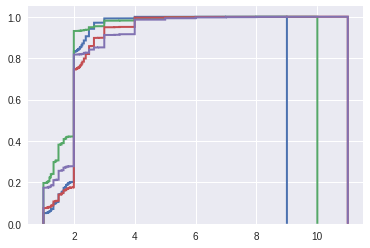

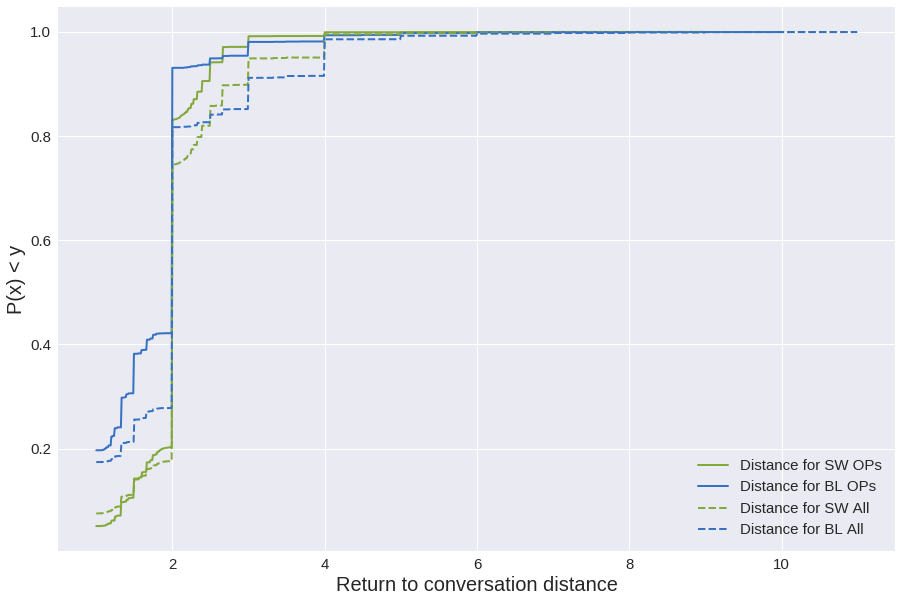

In [21]:
n1 , bins1 , patches1 = plt.hist([SW_opReturnFactor[k][0] for k in SW_opReturnFactor], 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)
n2 , bins2 , patches2 = plt.hist([BL_opReturnFactor[k][0] for k in BL_opReturnFactor], 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)
n3 , bins3 , patches3 = plt.hist([SW_ReturnFactor[k][0] for k in SW_ReturnFactor], 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)
n4 , bins4 , patches4 = plt.hist([BL_ReturnFactor[k][0] for k in BL_ReturnFactor], 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)


fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
ax.plot(bins1[:-1], n1, 'g', linewidth=2)
ax.plot(bins2[:-1], n2, 'b', linewidth=2)
ax.plot(bins3[:-1], n3, 'g--', linewidth=2)
ax.plot(bins4[:-1], n4, 'b--', linewidth=2)

# plt.title("Clustering of User interaction Graphs", fontsize = 20)
plt.xlabel("Return to conversation distance",fontsize = 20)
plt.ylabel("P(x) < y",fontsize = 20)
plt.legend(['Distance for SW OPs','Distance for BL OPs','Distance for SW All','Distance for BL All'], loc='lower right',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.grid()
plt.show()

(array([-0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5]),
 <a list of 7 Text xticklabel objects>)

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 <a list of 8 Text yticklabel objects>)

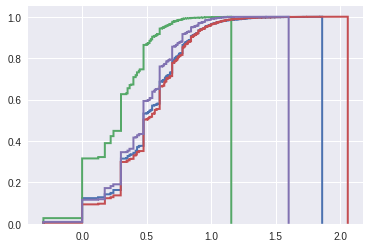

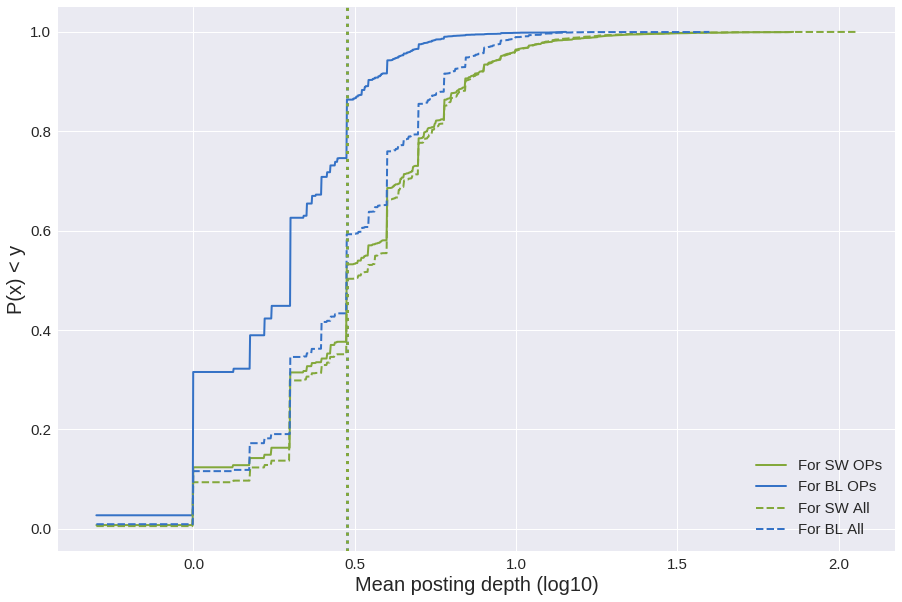

In [22]:
n1 , bins1 , patches1 = plt.hist(np.log10([SW_opReturnFactor[k][1]+1 for k in SW_opReturnFactor]), 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)
n2 , bins2 , patches2 = plt.hist(np.log10([BL_opReturnFactor[k][1]+1 for k in BL_opReturnFactor]), 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)
n3 , bins3 , patches3 = plt.hist(np.log10([SW_ReturnFactor[k][1]+1 for k in SW_ReturnFactor]), 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)
n4 , bins4 , patches4 = plt.hist(np.log10([BL_ReturnFactor[k][1]+1 for k in BL_ReturnFactor]), 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)


fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
ax.plot(bins1[:-1], n1, 'g', linewidth=2)
ax.plot(bins2[:-1], n2, 'b', linewidth=2)
ax.plot(bins3[:-1], n3, 'g--', linewidth=2)
ax.plot(bins4[:-1], n4, 'b--', linewidth=2)


ax.axvline(x=np.median(np.log10([BL_ReturnFactor[k][1]+1 for k in BL_ReturnFactor])), ymin=0, ymax=1, linewidth=3, color = 'b', linestyle='dotted')
ax.axvline(x=np.median(np.log10([SW_ReturnFactor[k][1]+1 for k in SW_ReturnFactor])), ymin=0, ymax=1, linewidth=3, color = 'g', linestyle='dotted')


# plt.title("Clustering of User interaction Graphs", fontsize = 20)
plt.xlabel("Mean posting depth (log10)",fontsize = 20)
plt.ylabel("P(x) < y",fontsize = 20)
plt.legend(['For SW OPs','For BL OPs','For SW All','For BL All'], loc='lower right',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.grid()
plt.show()

In [23]:
SW_branching = getBranchingFactor(ReplyGraphs_SW)

found a node with malformed data t3_g5rqg in graph g5u9u


In [24]:
BL_branching = getBranchingFactor(ReplyGraphs_BL)

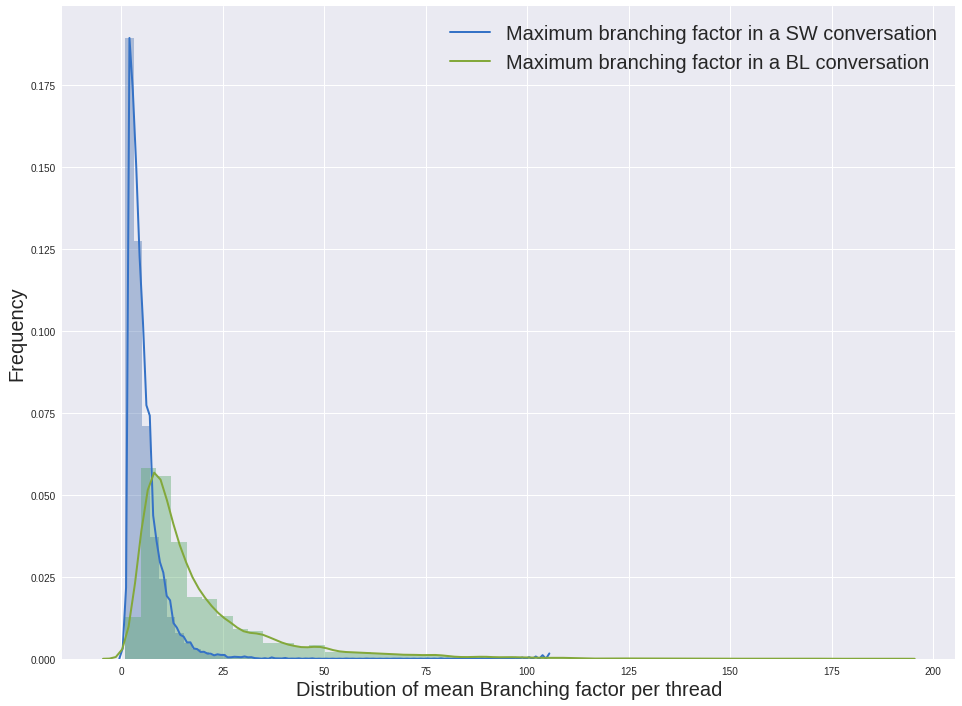

In [25]:
fig, ax = plt.subplots()
fig.set_size_inches(16,12)
sns.set(font_scale=2) 
sns.distplot([SW_branching[k][2] for k in SW_branching],kde_kws={"color": "b", "lw": 2, "label": "Maximum branching factor in a SW conversation"})
sns.distplot([BL_branching[k][2] for k in BL_branching],kde_kws={"color": "g", "lw": 2, "label": "Maximum branching factor in a BL conversation"})
# ax.axvline(x=np.median(medTopicalSW), ymin=0, ymax=1, linewidth=3, color = 'b', linestyle='dotted')
# ax.axvline(x=np.median(medTopicalBL), ymin=0, ymax=1, linewidth=3, color = 'g', linestyle='dotted')
plt.xlabel("Distribution of mean Branching factor per thread" , fontsize = 20)
plt.ylabel("Frequency" , fontsize = 20 )

In [26]:
BL_sorted_TA[-10:]

[(u'81x49o', 0.8702167451381684),
 (u'7zwkaq', 0.8802485346794129),
 (u'7zvu84', 0.8953911542892456),
 (u'819aaf', 0.9012245416641236),
 (u'825c7z', 0.9312152147293091),
 (u'7zmkq8', 0.9361676454544068),
 (u'80lsw5', 0.9406222879886628),
 (u'7z46vs', 0.9507737040519715),
 (u'814gcj', 0.9507791876792908),
 (u'80lwfx', 0.953444528579712)]

35


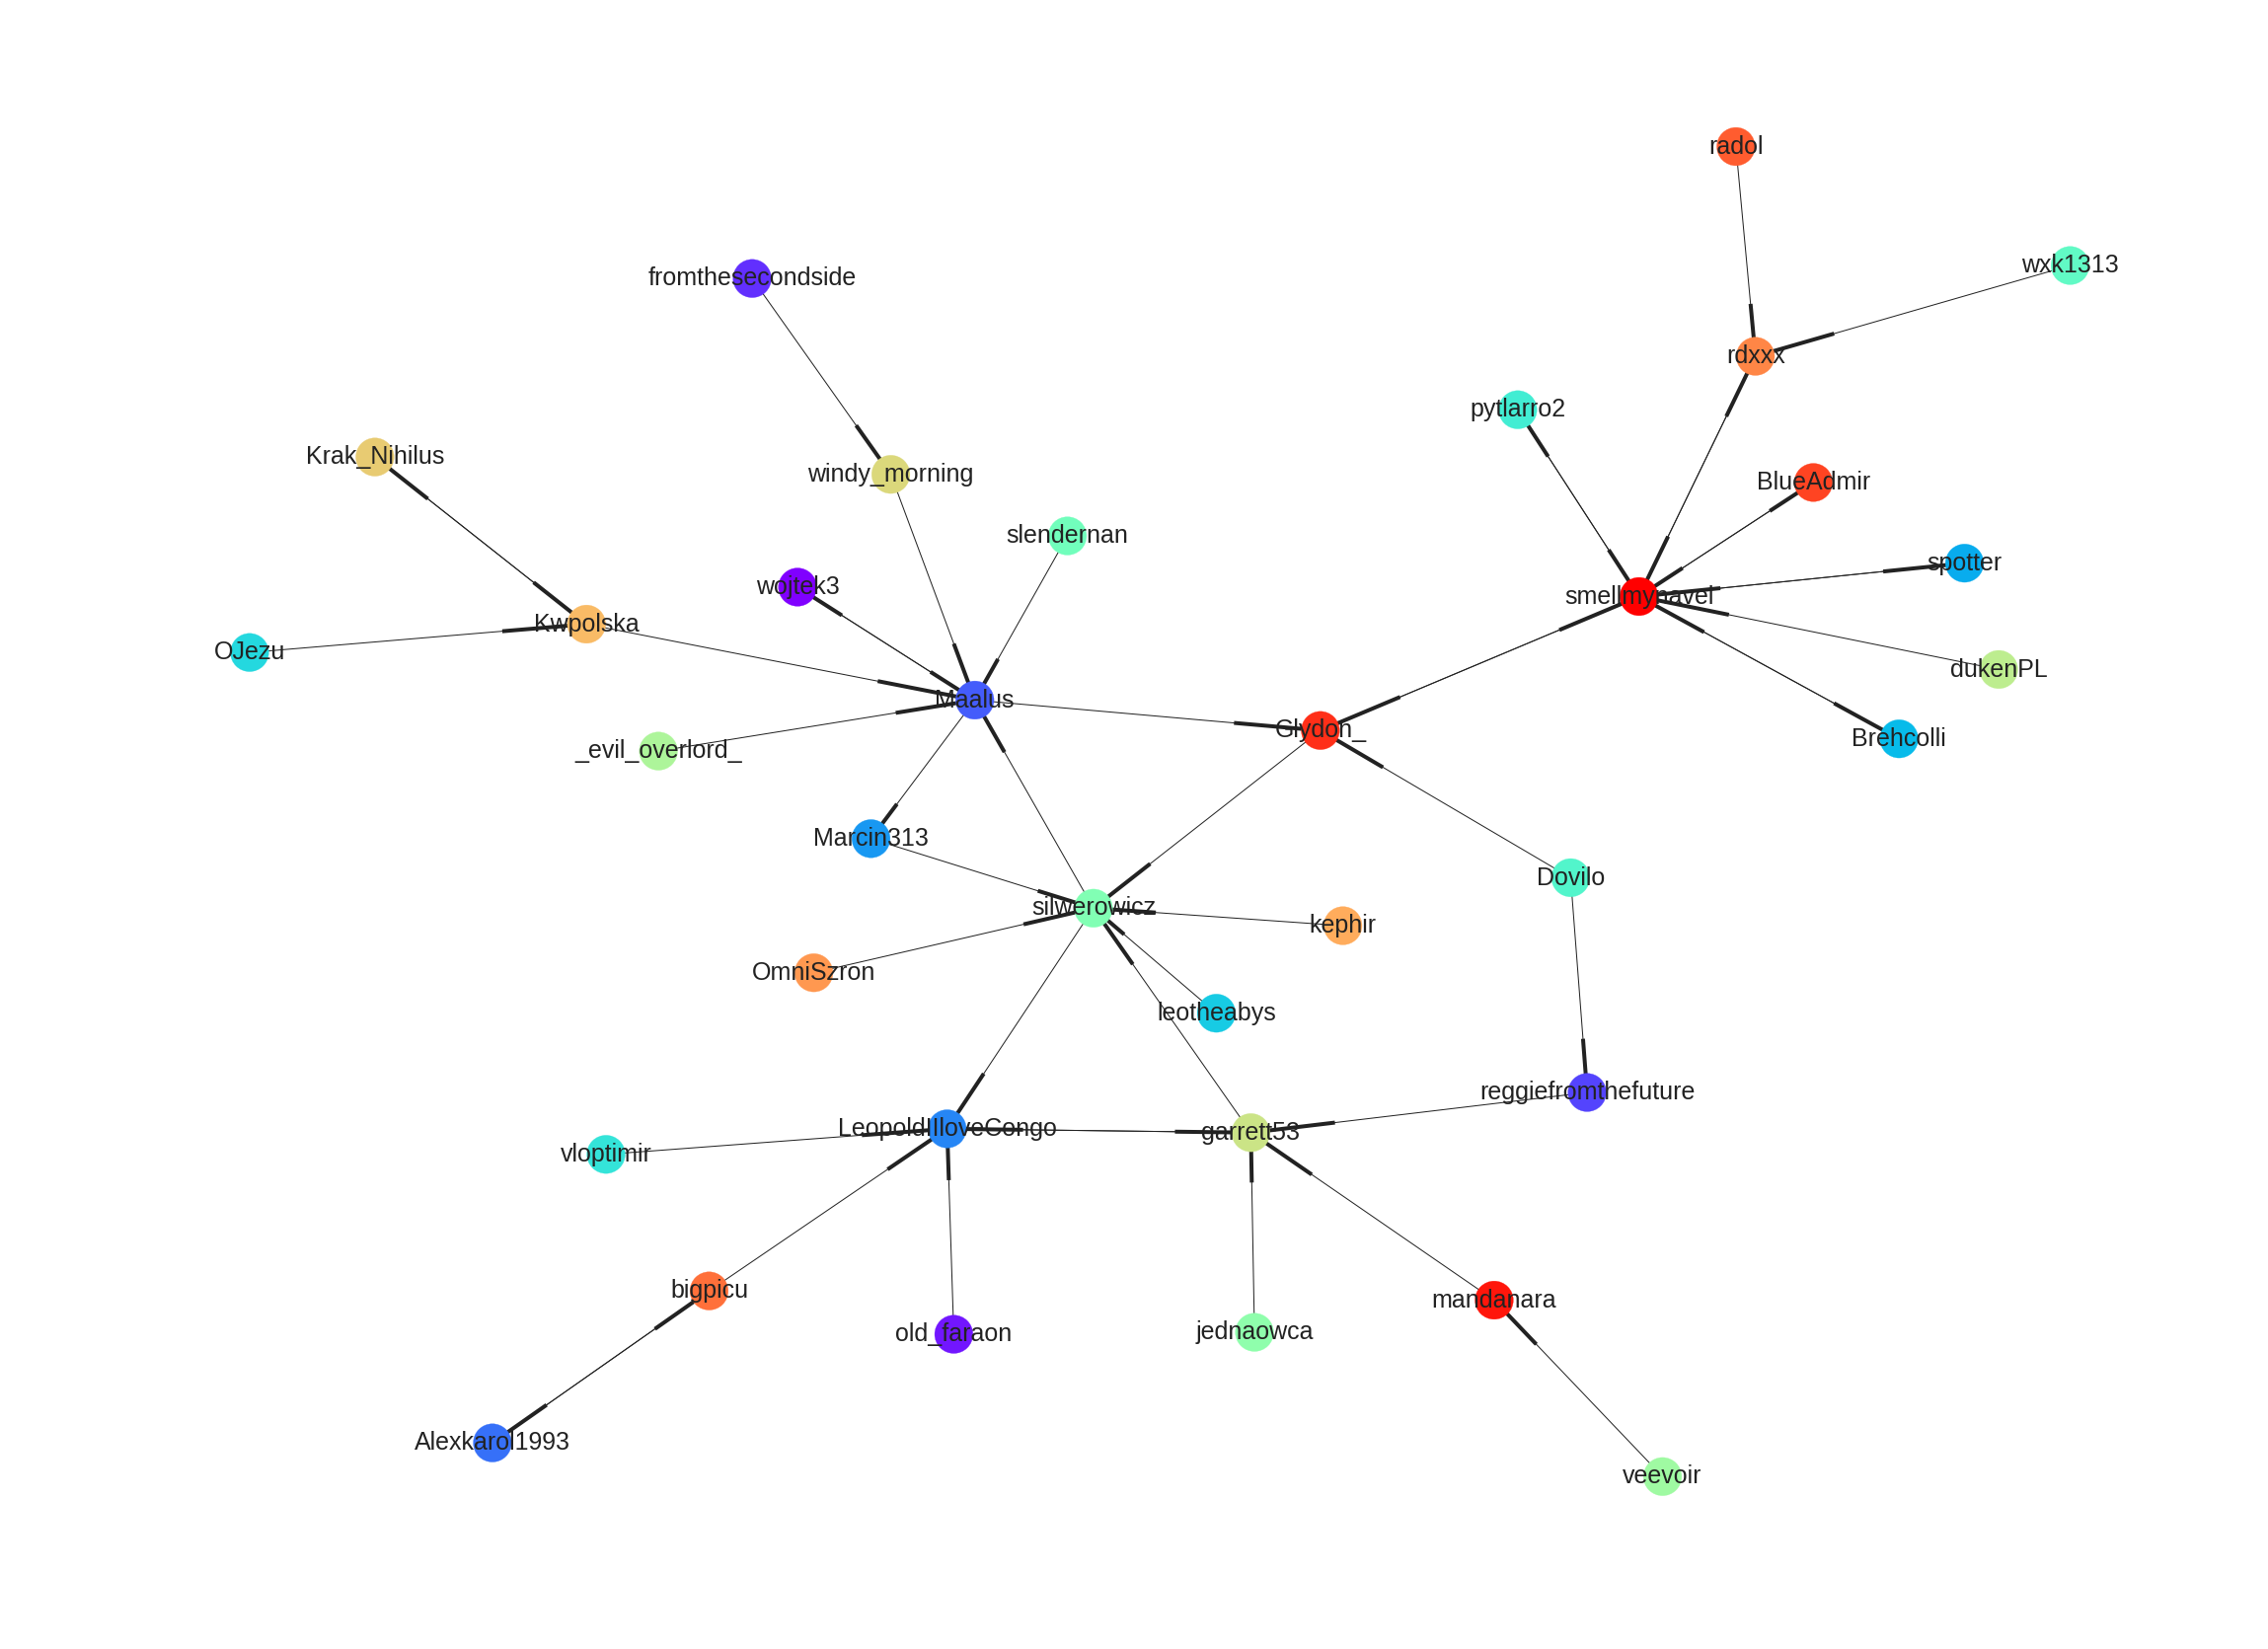

In [27]:
drawUserGraph(BL_Graphs[BL_sorted_TA[-10][0]])

2


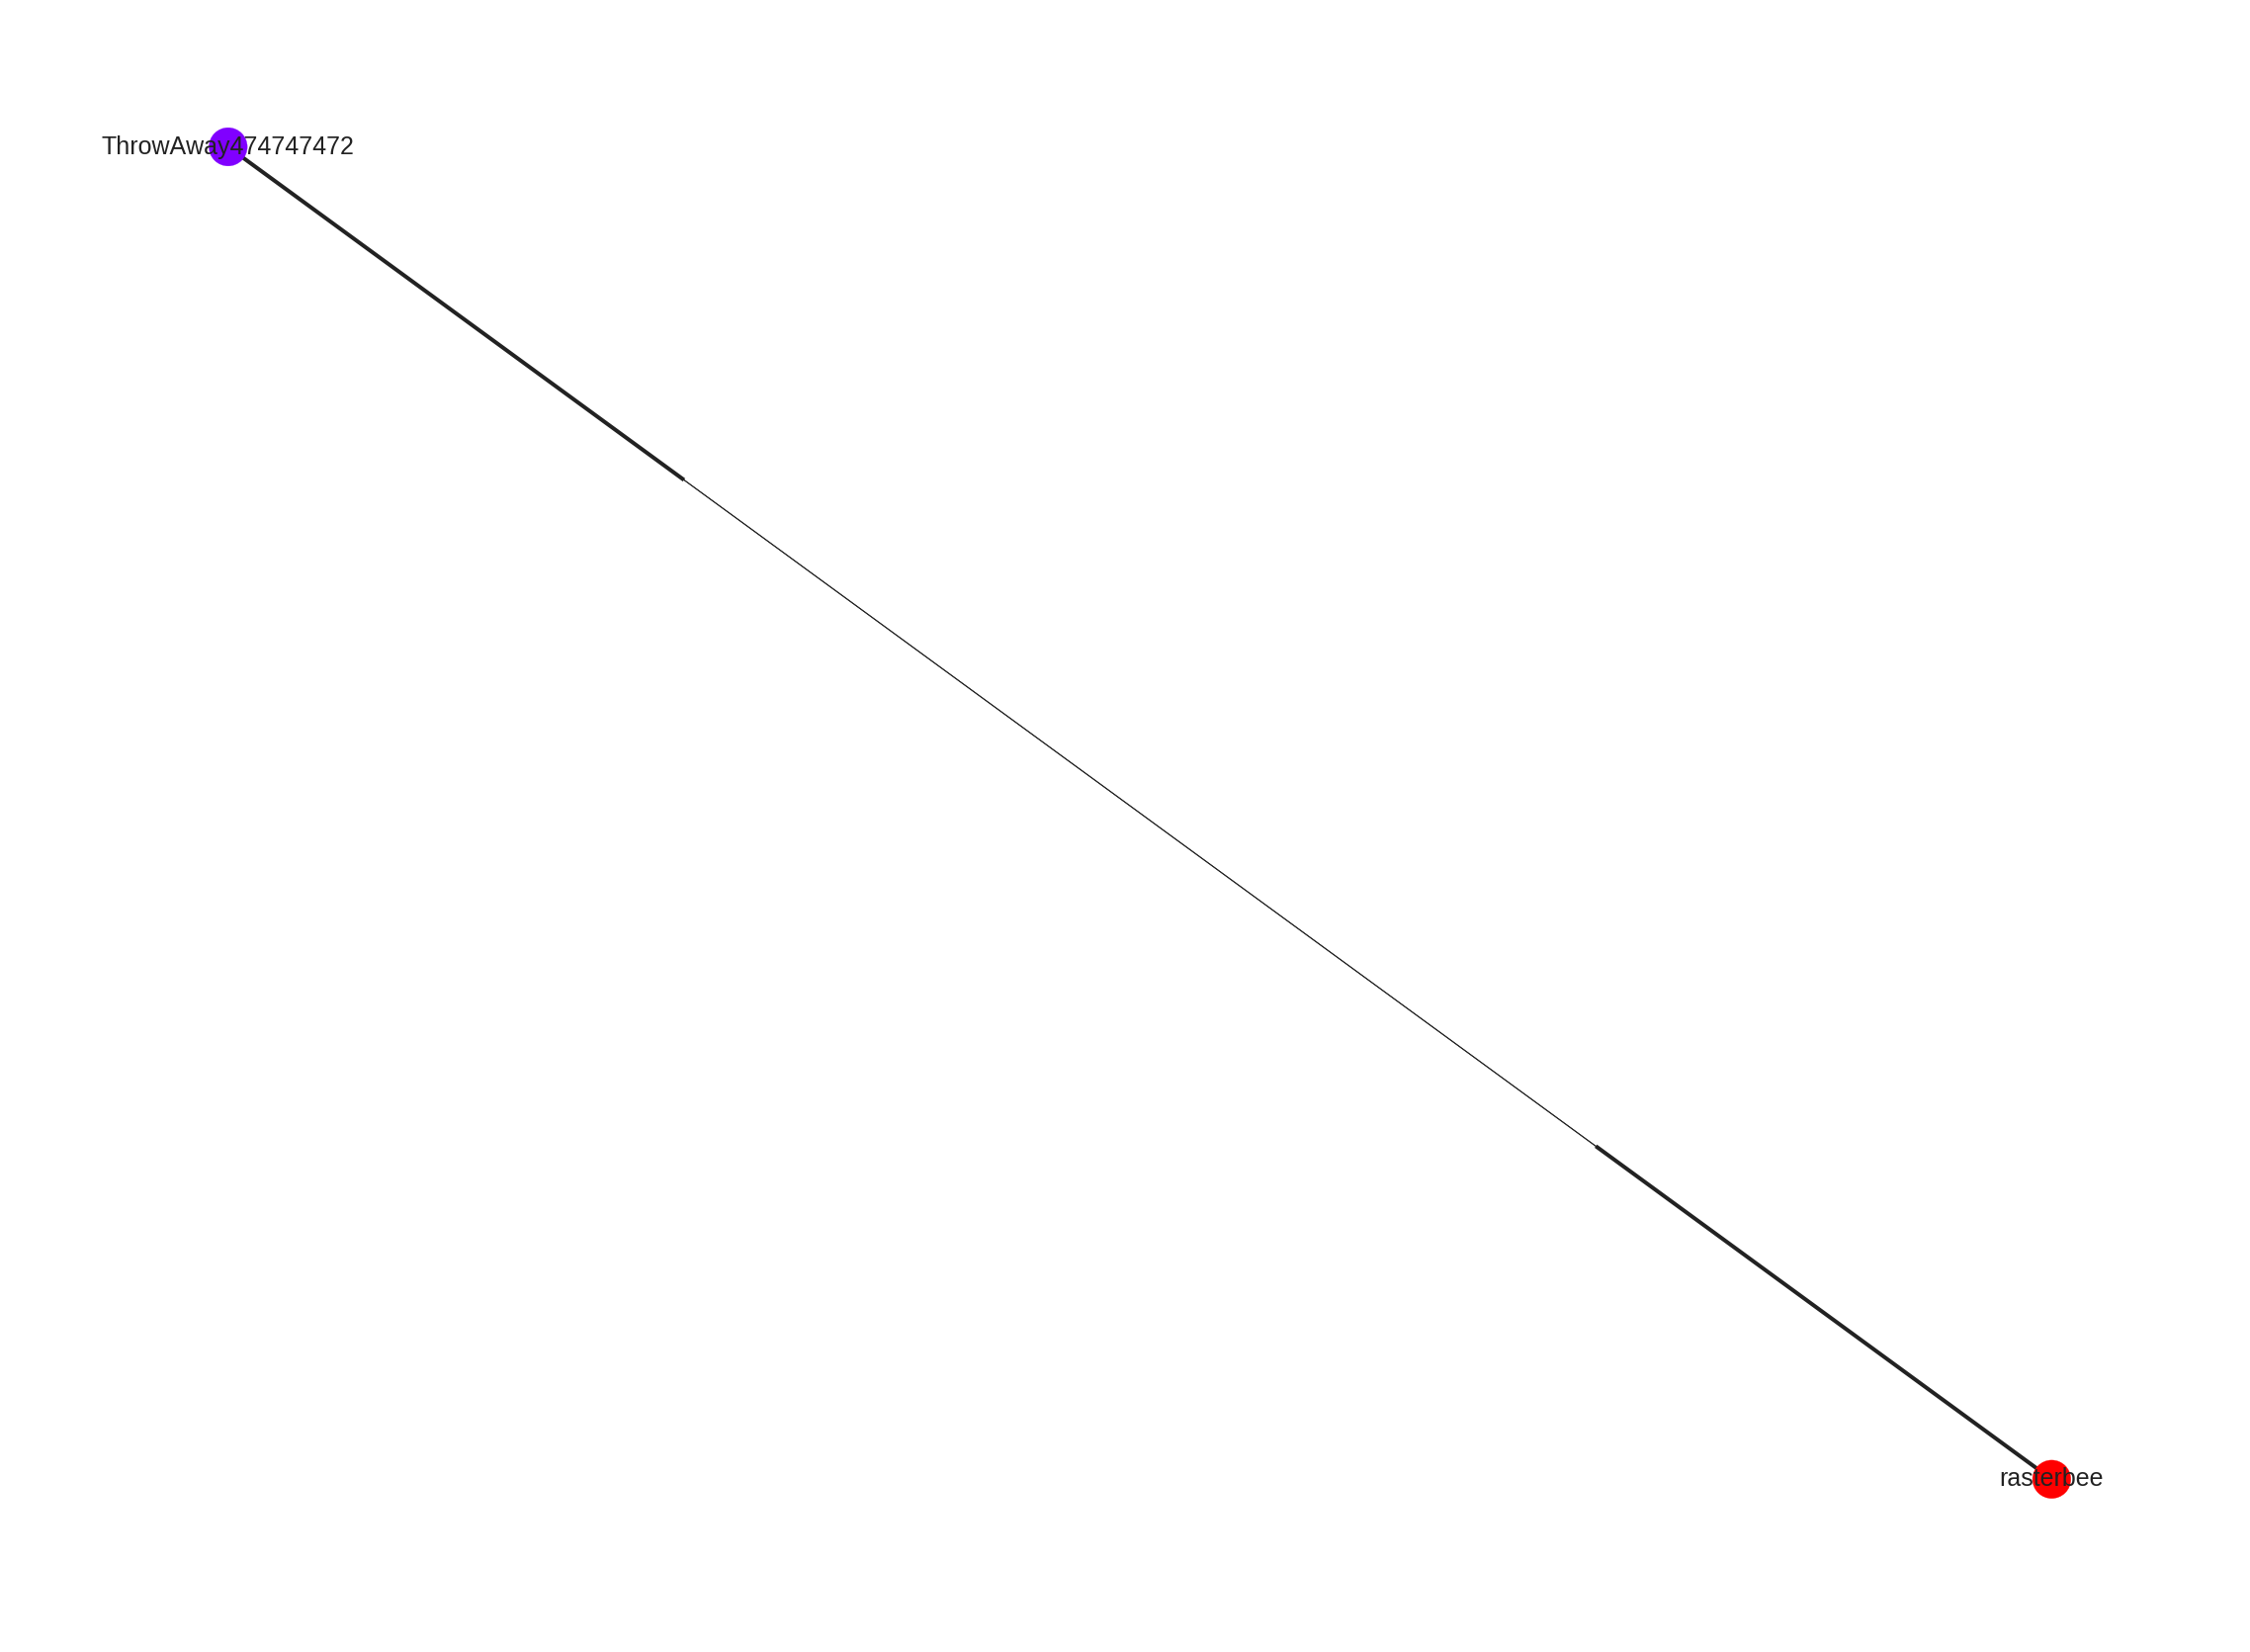

In [28]:
drawUserGraph(SW_Graphs[SW_sorted_TA[-15][0]])

In [29]:
len(BL_medCentralities) , len(SW_medCentralities)

(11070, 10527)

In [30]:
BL_medCentralities

[0.43315508021390375,
 0.3939393939393939,
 0.45,
 0.48333333333333334,
 0.22613065326633167,
 0.475,
 0.22655169828921723,
 0.4090909090909091,
 0.2916666666666667,
 0.3076923076923077,
 0.32120905952681655,
 0.34814814814814815,
 0.47368421052631576,
 0.2536231884057971,
 0.3865546218487395,
 0.42424242424242425,
 0.3696369636963696,
 0.2981871994080651,
 0.4772727272727273,
 0.3728813559322034,
 0.4507042253521127,
 0.2810810810810811,
 0.45454545454545453,
 0.375,
 0.42857142857142855,
 0.337664615716753,
 0.3958333333333333,
 0.37037037037037035,
 0.47058823529411764,
 0.24442750797589508,
 0.4642857142857143,
 0.2777777777777778,
 0.4107142857142857,
 0.3898305084745763,
 0.48684210526315785,
 0.1915750915750916,
 0.3958333333333333,
 0.25449101796407186,
 0.42857142857142855,
 0.424,
 0.4,
 0.39473684210526316,
 0.32,
 0.4525862068965517,
 0.3335526315789474,
 0.4358974358974359,
 0.4117647058823529,
 0.40551181102362205,
 0.3776223776223776,
 0.4107142857142857,
 0.483870967741

In [37]:
# medTopicalSW , TopicalSpreadSW = getTopicMetrics(SW_Graphs)

In [ ]:
# len(medTopicalSW) , len(TopicalSpreadSW)

In [ ]:
# medTopicalBL , TopicalSpreadBL = getTopicMetrics(BL_Graphs)

In [ ]:
# len(medTopicalBL) , len(TopicalSpreadBL)

In [32]:
print len(SW_opCentralities) , len(BL_opCentralities)

10527 11070


In [33]:
len(BL_medClusterings) , len(SW_medClusterings)

(11070, 10527)

In [34]:
topicAlignmentAll_BL = getTopicdist(ReplyGraphs_BL)

In [35]:
len(topicAlignmentAll_BL[0])

11070

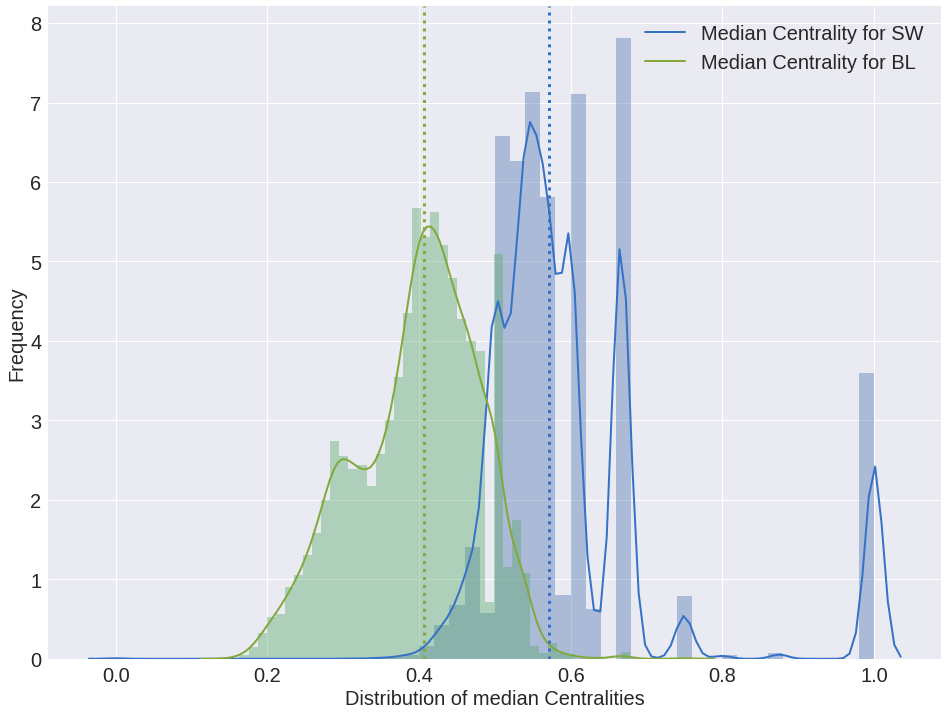

In [38]:
fig, ax = plt.subplots()
fig.set_size_inches(16,12)
sns.set(font_scale=2) 
sns.distplot(SW_medCentralities,kde_kws={"color": "b", "lw": 2, "label": "Median Centrality for SW"})
sns.distplot(BL_medCentralities,kde_kws={"color": "g", "lw": 2, "label": "Median Centrality for BL"})
ax.axvline(x=np.median(SW_medCentralities), ymin=0, ymax=1, linewidth=3, color = 'b', linestyle='dotted')
ax.axvline(x=np.median(BL_medCentralities), ymin=0, ymax=1, linewidth=3, color = 'g', linestyle='dotted')
plt.xlabel("Distribution of median Centralities" , fontsize = 20)
plt.ylabel("Frequency" , fontsize = 20 )

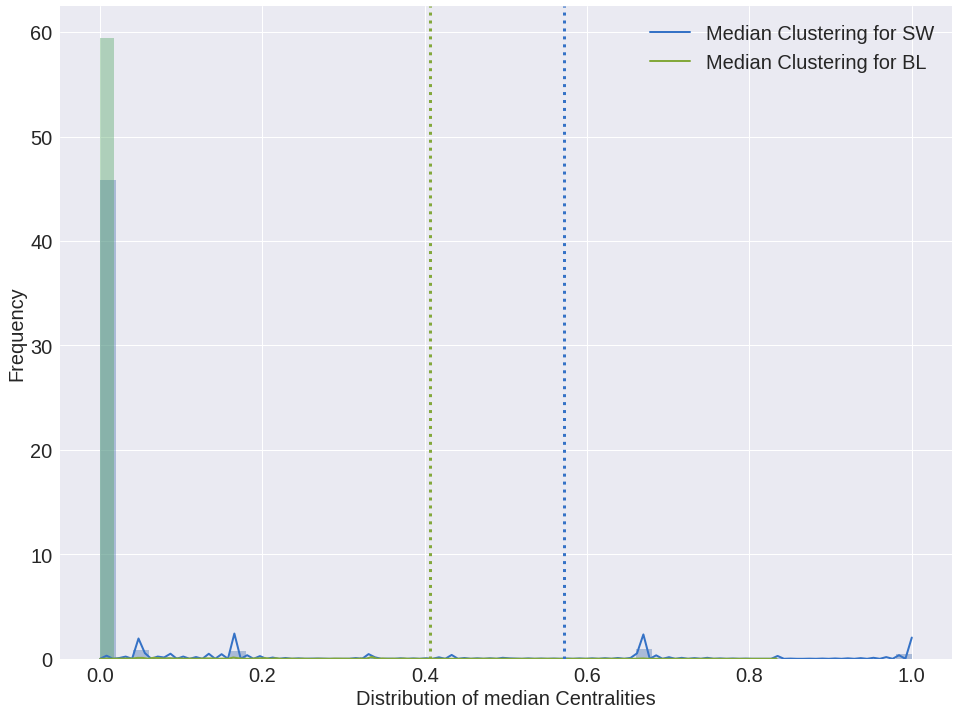

In [39]:
fig, ax = plt.subplots()
fig.set_size_inches(16,12)
sns.set(font_scale=2) 
sns.distplot(SW_medClusterings,kde_kws={"color": "b", "lw": 2, "label": "Median Clustering for SW"})
sns.distplot(BL_medClusterings,kde_kws={"color": "g", "lw": 2, "label": "Median Clustering for BL"})
ax.axvline(x=np.median(SW_medCentralities), ymin=0, ymax=1, linewidth=3, color = 'b', linestyle='dotted')
ax.axvline(x=np.median(BL_medCentralities), ymin=0, ymax=1, linewidth=3, color = 'g', linestyle='dotted')
plt.xlabel("Distribution of median Centralities" , fontsize = 20)
plt.ylabel("Frequency" , fontsize = 20 )

In [ ]:
nx.__version__

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 <a list of 8 Text xticklabel objects>)

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 <a list of 8 Text yticklabel objects>)

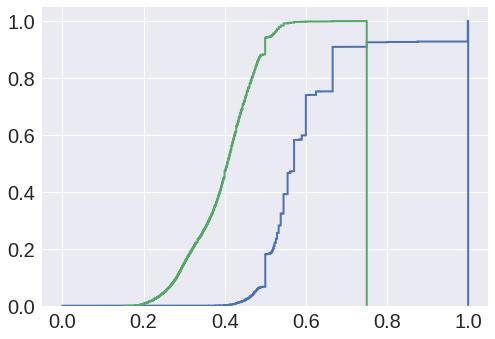

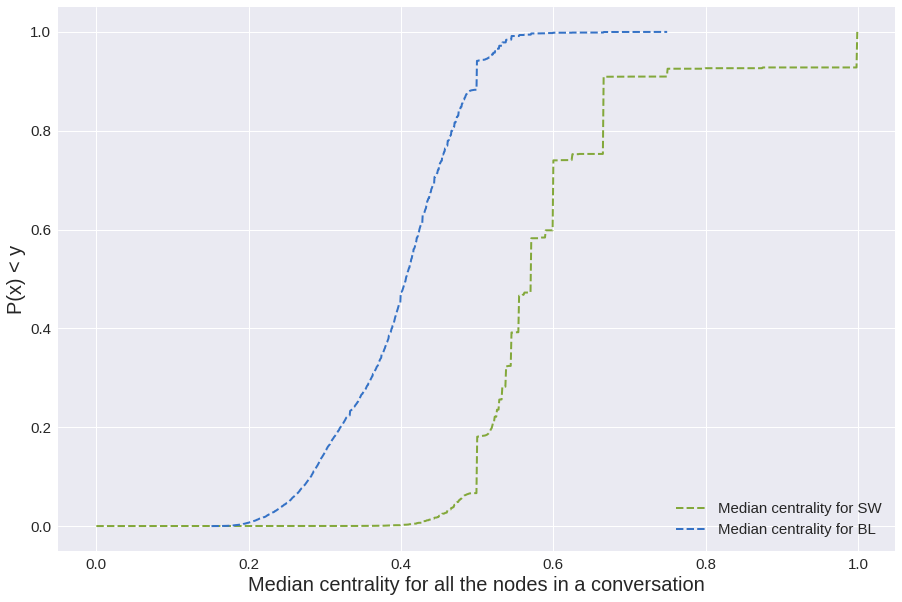

In [41]:
n1_all , bins1_all , patches1 = plt.hist(SW_medCentralities, 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)
n2_all , bins2_all , patches2 = plt.hist(BL_medCentralities, 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)

fig, ax = plt.subplots()
fig.set_size_inches(15, 10)

ax.plot(bins1_all[:-1], n1_all, 'g--', linewidth=2)
ax.plot(bins2_all[:-1], n2_all, 'b--', linewidth=2)

plt.xlabel("Median centrality for all the nodes in a conversation",fontsize = 20)
plt.ylabel("P(x) < y",fontsize = 20)
plt.legend(['Median centrality for SW','Median centrality for BL'], loc='lower right',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.grid()
plt.show()

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 <a list of 8 Text xticklabel objects>)

(array([0.9 , 0.92, 0.94, 0.96, 0.98, 1.  , 1.02]),
 <a list of 7 Text yticklabel objects>)

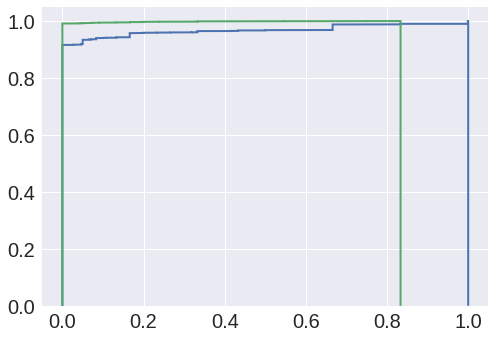

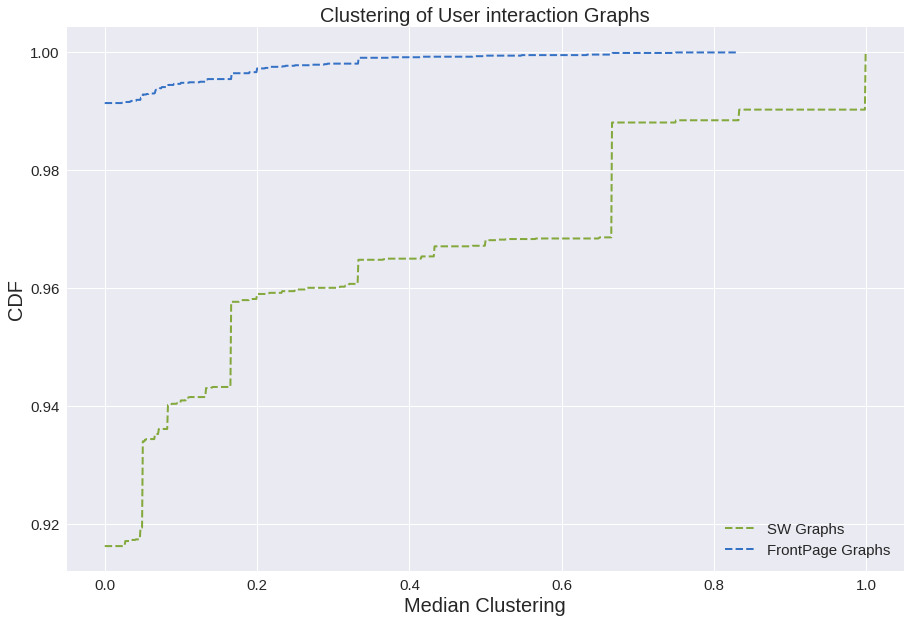

In [42]:
n1 , bins1 , patches1 = plt.hist(SW_medClusterings, 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)
n2 , bins2 , patches2 = plt.hist(BL_medClusterings, 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)

fig, ax = plt.subplots()
fig.set_size_inches(15, 10)

ax.plot(bins1[:-1], n1, 'g--', linewidth=2)
ax.plot(bins2[:-1], n2, 'b--', linewidth=2)

plt.title("Clustering of User interaction Graphs", fontsize = 20)
plt.xlabel("Median Clustering",fontsize = 20)
plt.ylabel("CDF",fontsize = 20)
plt.legend(['SW Graphs','FrontPage Graphs'], loc='lower right',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.grid()
plt.show()

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 <a list of 8 Text xticklabel objects>)

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 <a list of 8 Text yticklabel objects>)

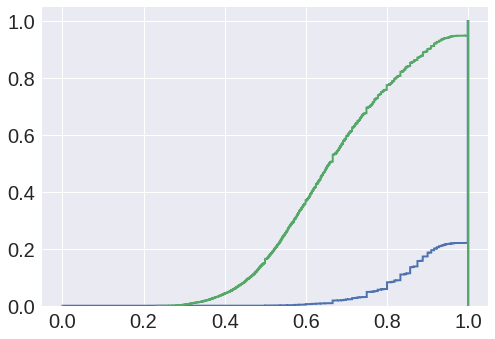

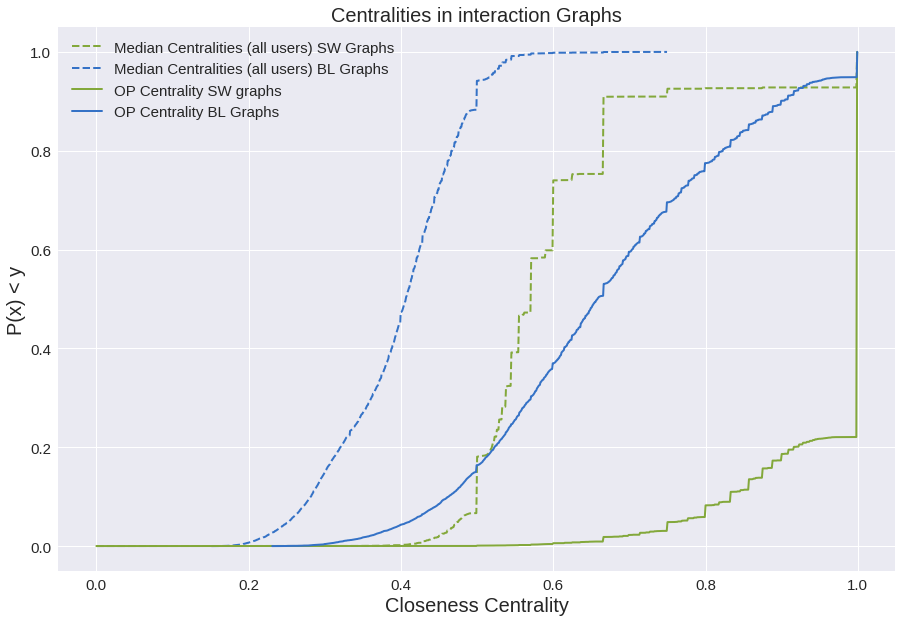

In [43]:
n1 , bins1 , patches1 = plt.hist(SW_opCentralities, 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)
n2 , bins2 , patches2 = plt.hist(BL_opCentralities, 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)

fig, ax = plt.subplots()
fig.set_size_inches(15, 10)

ax.plot(bins1_all[:-1], n1_all, 'g--', linewidth=2)
ax.plot(bins2_all[:-1], n2_all, 'b--', linewidth=2)

ax.plot(bins1[:-1], n1, 'g', linewidth=2)
ax.plot(bins2[:-1], n2, 'b', linewidth=2)

plt.title("Centralities in interaction Graphs", fontsize = 20)
plt.xlabel("Closeness Centrality",fontsize = 20)
plt.ylabel("P(x) < y",fontsize = 20)
plt.legend(['Median Centralities (all users) SW Graphs','Median Centralities (all users) BL Graphs','OP Centrality SW graphs','OP Centrality BL Graphs'], loc='top left',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.grid()
plt.show()

(array([-0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,  1.75,
         2.  ]), <a list of 10 Text xticklabel objects>)

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 <a list of 8 Text yticklabel objects>)

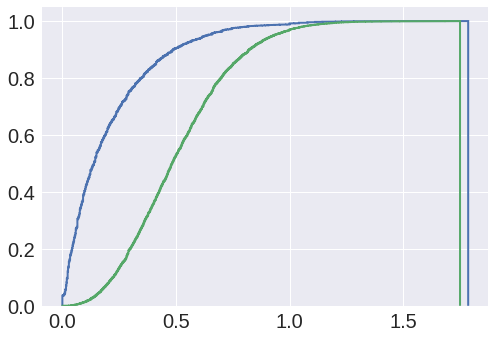

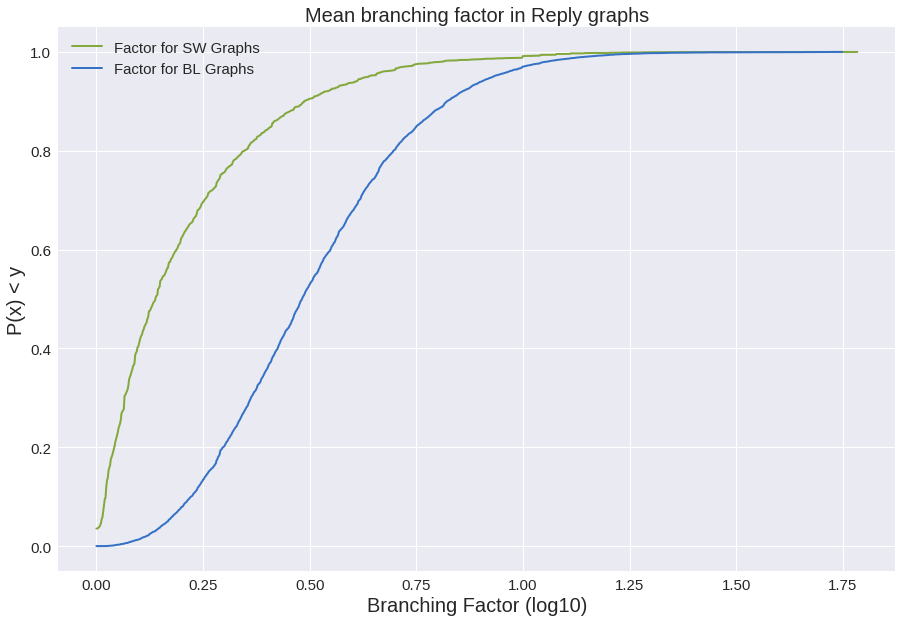

In [44]:
n1 , bins1 , patches1 = plt.hist(np.log10([SW_branching[k][0] for k in SW_branching]), 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)
n2 , bins2 , patches2 = plt.hist(np.log10([BL_branching[k][0] for k in BL_branching]), 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)

fig, ax = plt.subplots()
fig.set_size_inches(15, 10)

ax.plot(bins1[:-1], n1, 'g', linewidth=2)
ax.plot(bins2[:-1], n2, 'b', linewidth=2)

plt.title("Mean branching factor in Reply graphs", fontsize = 20)
plt.xlabel("Branching Factor (log10)",fontsize = 20)
plt.ylabel("P(x) < y",fontsize = 20)
plt.legend(['Factor for SW Graphs','Factor for BL Graphs'], loc='top left',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.grid()
plt.show()

In [45]:
len(ReplyGraphs_SW), len(ReplyGraphs_BL)

(10527, 11070)

In [46]:
# commonKeys_BL= (set(ReplyGraphs_BL.keys()).intersection(BL_Graphs.keys()))
# len(commonKeys_BL)

In [47]:
# commonKeys_SW_all= (set(ReplyGraphs_SW.keys()).intersection(SW_Graphs.keys()))
# commonKeys_SW = random.sample(commonKeys_SW_all,len(commonKeys_BL))
# len(commonKeys_SW)

In [48]:
commonKeys_BL= [k for k in BL_Graphs if len(BL_Graphs[k].nodes()) >= 3]
print len(commonKeys_BL)

11070


In [49]:
commonKeys_SW= [k for k in SW_Graphs if len(SW_Graphs[k].nodes()) >= 3]
print len(commonKeys_SW)

9857


In [50]:
# |drawReplyGraph(ReplyGraphs_BL[ReplyGraphs_BL.keys()[11]])

In [51]:
ReplyGraphs_BL[ReplyGraphs_BL.keys()[11]].nodes(data=True)

[(u't1_duycd9j',
  {'affects': 25.77,
   'author': u'420throw666',
   'depth': 0,
   'downs': 0,
   'text': 'WHAT IN SWEET BABY RAYS NAME IS THIS FUCKERY',
   'time': 1519811905.0,
   'ups': 6}),
 (u't1_duyeurr',
  {'affects': 25.77,
   'author': u'frumps',
   'depth': 2,
   'downs': 0,
   'text': 'I wouldn\xe2\x80\x99t want to know what\xe2\x80\x99s been done to that tube. ',
   'time': 1519817964.0,
   'ups': 6}),
 (u't1_duybt52',
  {'affects': 25.77,
   'author': u'SullenTerror',
   'depth': 0,
   'downs': 0,
   'text': 'r/blackmagicfuckery',
   'time': 1519810501.0,
   'ups': 18}),
 (u't1_duyff65',
  {'affects': 25.77,
   'author': u'CrunchHardtack',
   'depth': 5,
   'downs': 0,
   'text': "I'm betting there will be no reply or he will have forgotten the name of this extremely memorable book.",
   'time': 1519819132.0,
   'ups': 5}),
 (u't1_duyfb2b',
  {'affects': 25.77,
   'author': u'ShiftyMctwizz',
   'depth': 0,
   'downs': 0,
   'text': 'Misread, expected /u/vernetroyer',
   

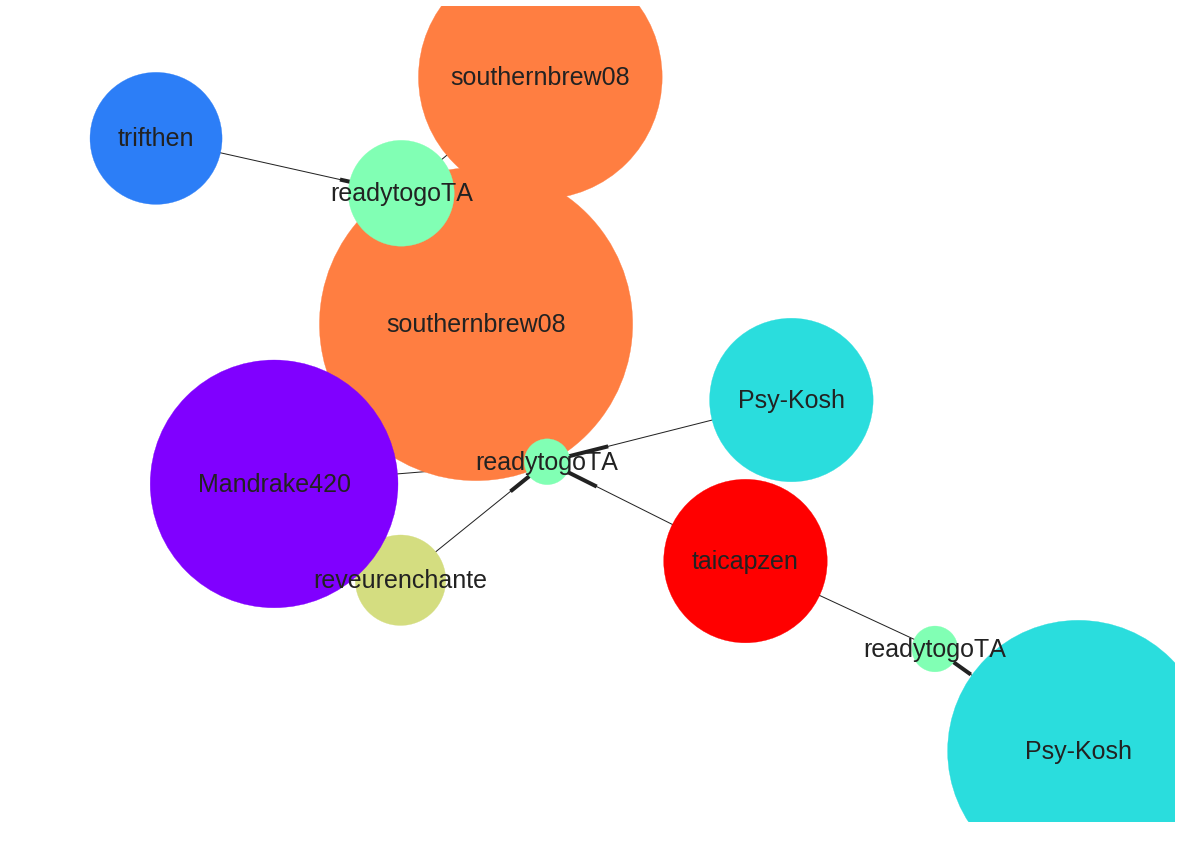

In [52]:
drawReplyGraph(ReplyGraphs_SW[SW_Graphs.keys()[10]])

5


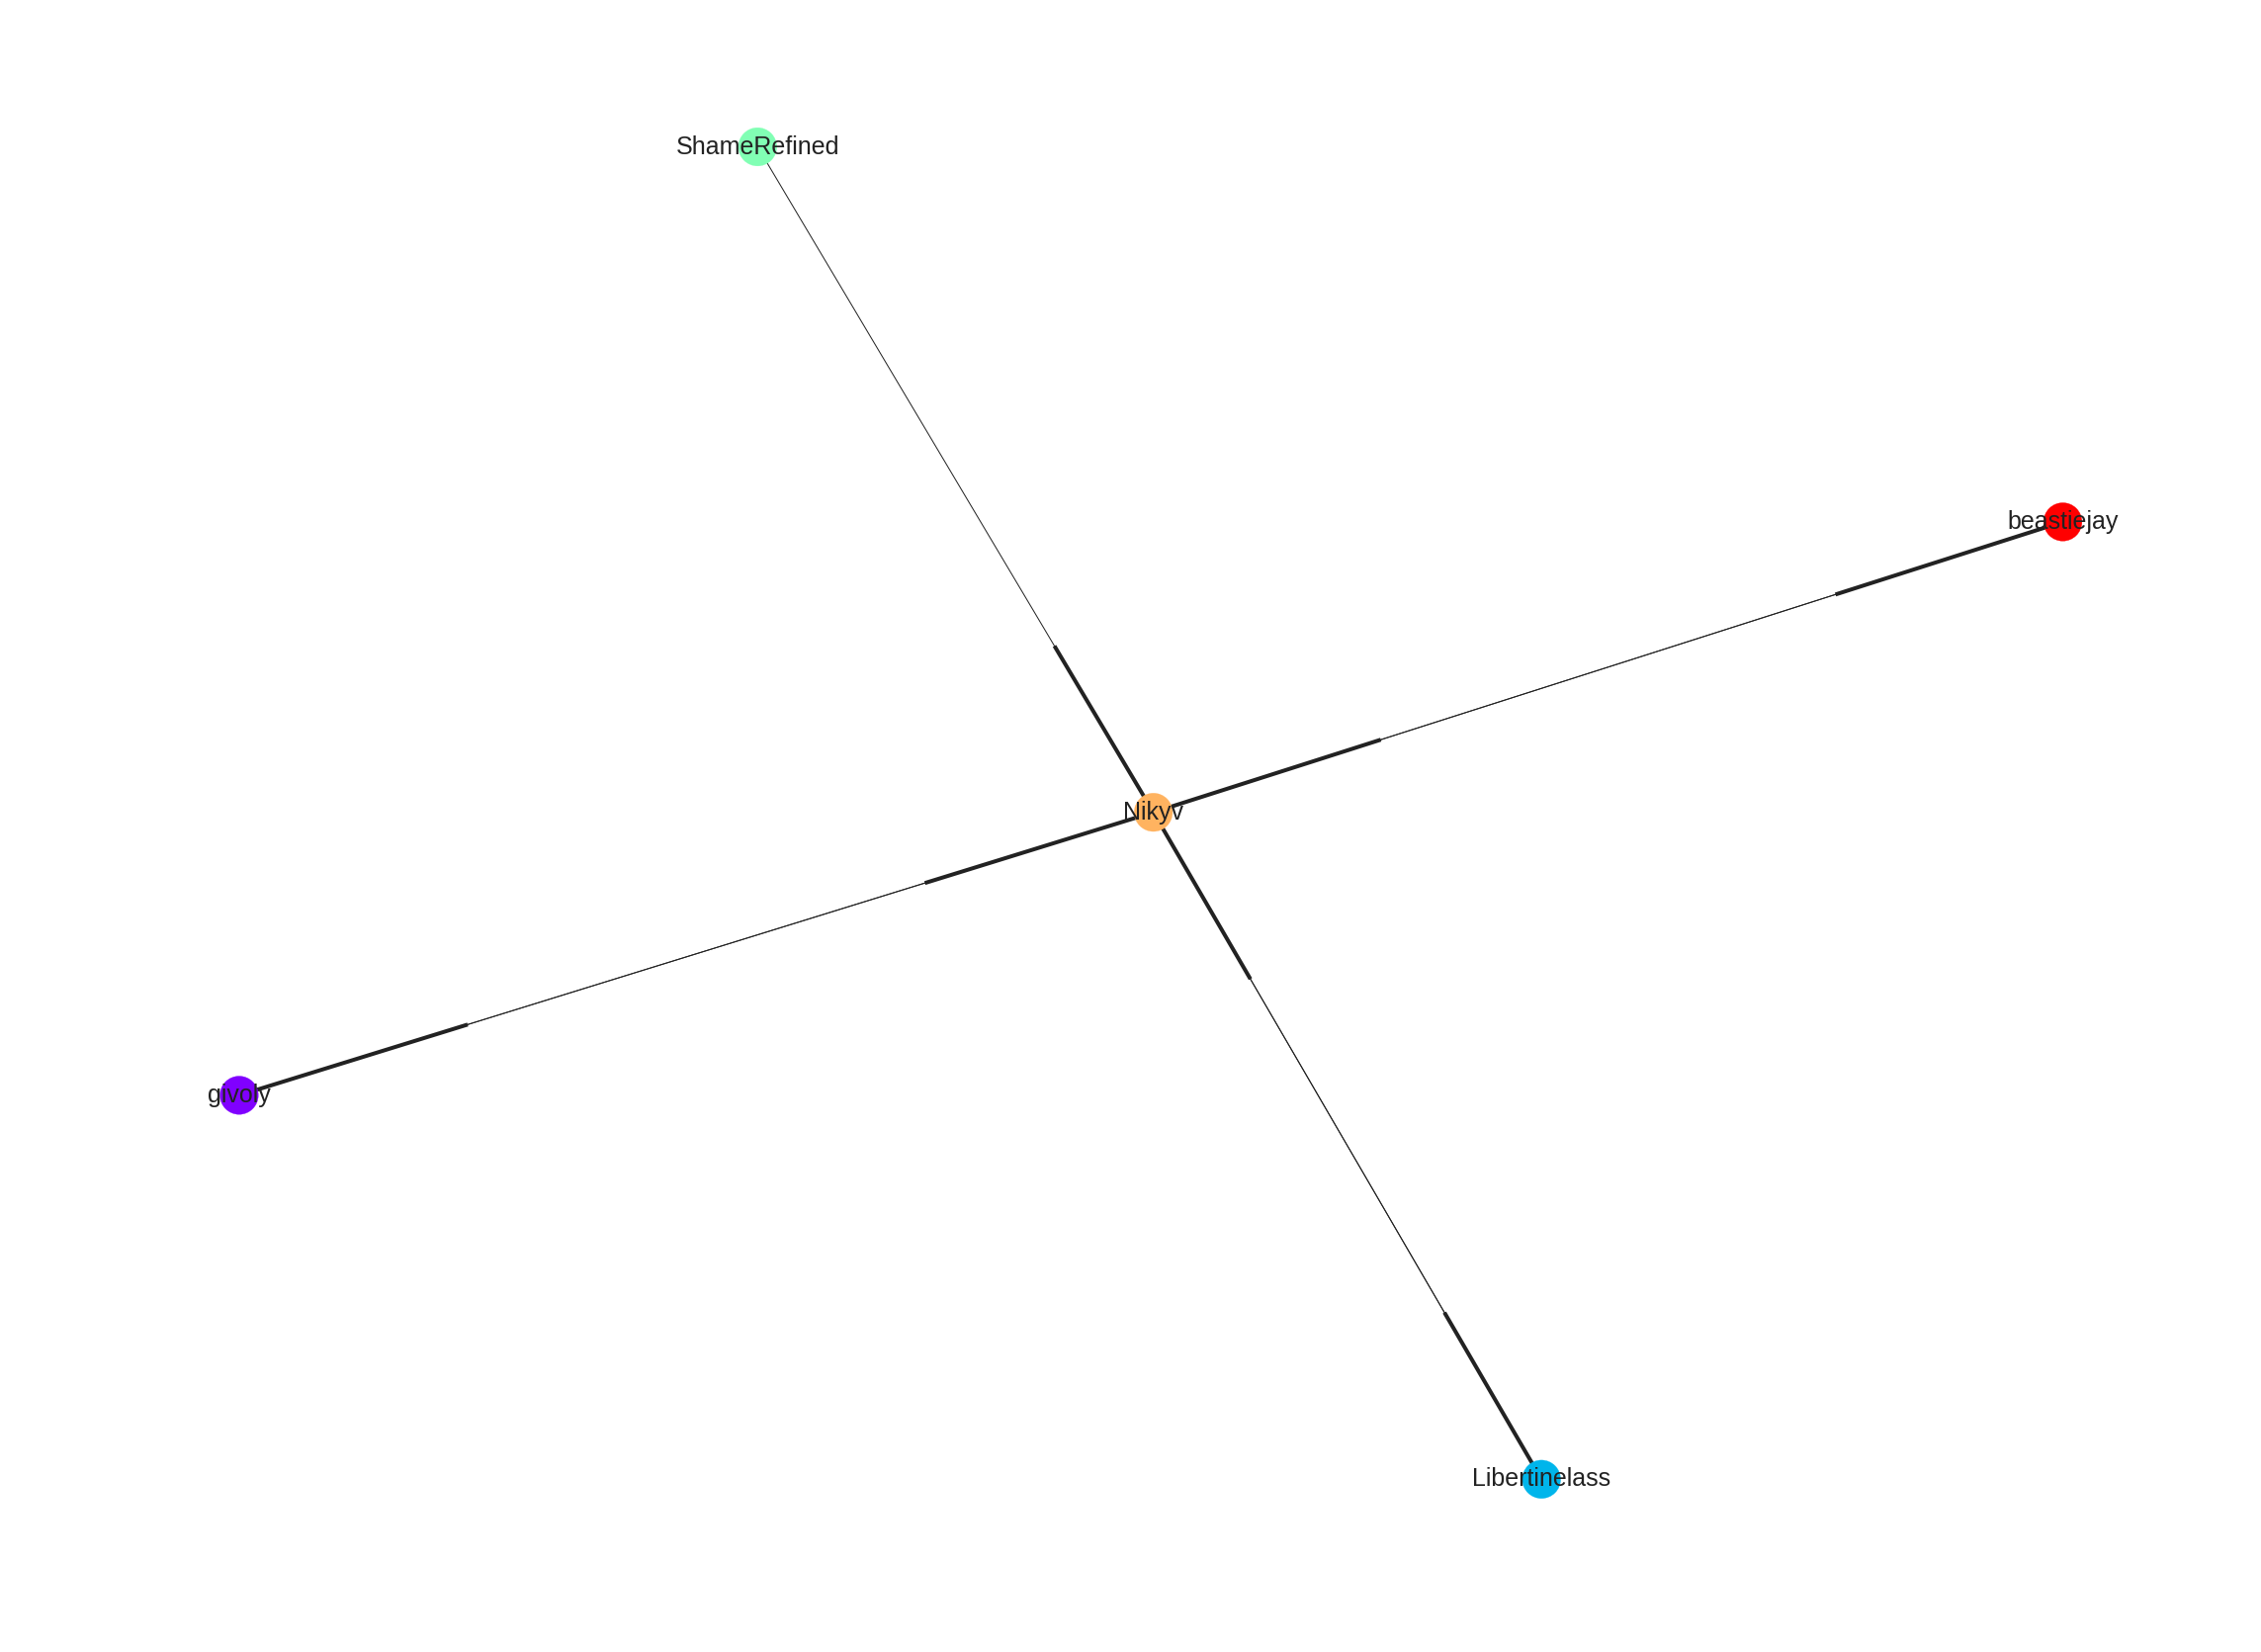

In [53]:
drawUserGraph(SW_Graphs[SW_Graphs.keys()[1011]])

In [54]:
print BL_Graphs[BL_Graphs.keys()[10]].edges(data=True)
print "---------------------------------------------"
print SW_Graphs[SW_Graphs.keys()[10]].edges(data=True)

[(u'bigde32', u'RepostSwat', {'timestamp': 1519772550.0, 'weight': 0.6274394273757935}), (u'bigde32', u'Pikachu1001000', {'timestamp': 1519766258.0, 'weight': -0.01435570120811458}), (u'Darkfire293', u'ConfusedRara', {'timestamp': 1519793099.0, 'weight': 0.3027638673782349}), (u'HeckinGoodDoggo', u'Pikachu1001000', {'timestamp': 1519856774.0, 'weight': 0.0637634258717299}), (u'RepostSwat', u'bigde32', {'timestamp': 1519771831.0, 'weight': 0.7168094396591187}), (u'cawkmonglingwitch', u'Pikachu1001000', {'timestamp': 1519777209.0, 'weight': -0.12951363325119014}), (u'tulpa_man', u'dukethedj', {'timestamp': 1519858881.0, 'weight': 0.1183868452906609}), (u'tulpa_man', u'Transhumaniste', {'timestamp': 1519855385.0, 'weight': 0.21252531111240391}), (u'tulpa_man', u'7aane', {'timestamp': 1520134891.0, 'weight': 0.17292385846376424}), (u'jboogie18', u'Pikachu1001000', {'timestamp': 1519810391.0, 'weight': 0.08142565861344342}), (u'ohlookahipster', u'bigde32', {'timestamp': 1519773449.0, 'weigh

In [55]:
[k[2]['timestamp'] for k in  BL_Graphs[BL_Graphs.keys()[1]].edges(data=True)]

[1519767002.0,
 1519737618.0,
 1519743103.0,
 1519759467.0,
 1519759268.0,
 1519741464.0,
 1519754961.0,
 1519763424.0,
 1519735576.0,
 1519744893.0,
 1519741112.0,
 1519738654.0,
 1519759406.0,
 1519766754.0,
 1519764482.0,
 1519766286.0,
 1519737984.0]

In [56]:
def getEdgeMetrics(graphs):
    EdgeWeight = []
    aggregateEdgeWeights = []
    varianceEdgeWeights = []
    for k in graphs:
        weights = [k[2]['weight'] for k in  graphs[k].edges(data=True)] 
        aggregateEdgeWeights+=weights
        meanWeight= np.median(weights)
        varWeight = np.var(weights)
        if np.isnan(meanWeight):
            print "Found Nan centrality"
            continue
        else:
            EdgeWeight.append(meanWeight)
        
        if np.isnan(varWeight):
            print "Found Nan Clustering"
            continue
        else:
            varianceEdgeWeights.append(varWeight)
        
    return EdgeWeight , varianceEdgeWeights 
    

In [57]:
SW_edgeWeights , SW_edgeVars = getEdgeMetrics(SW_Graphs)

In [58]:
BL_edgeWeights , BL_edgeVars = getEdgeMetrics(BL_Graphs)

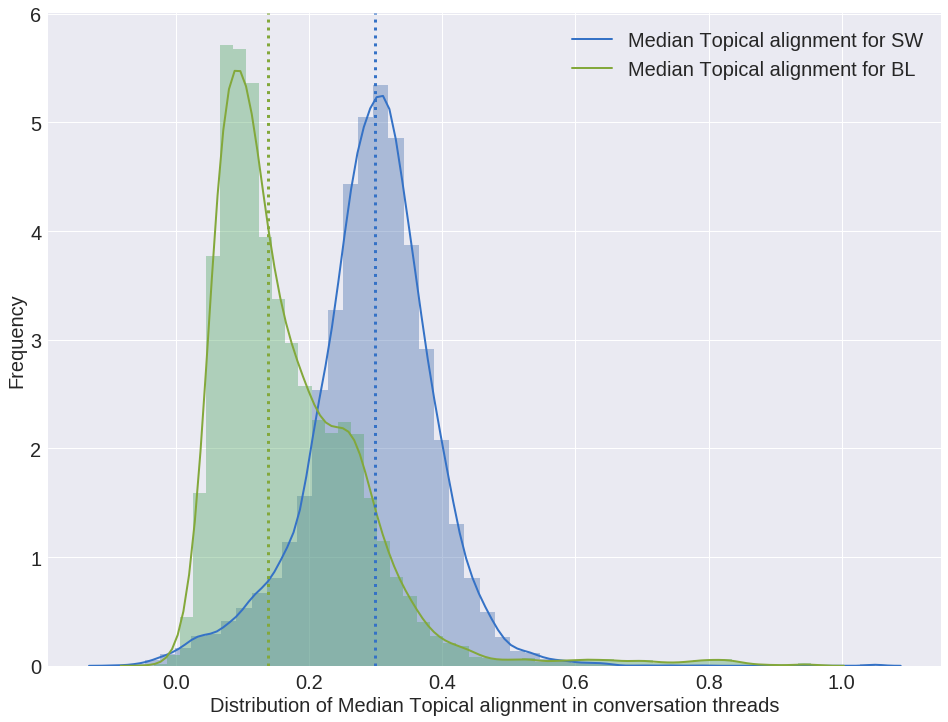

In [59]:
fig, ax = plt.subplots()
fig.set_size_inches(16,12)
sns.set(font_scale=2) 
sns.distplot(SW_edgeWeights,kde_kws={"color": "b", "lw": 2, "label": "Median Topical alignment for SW"})
sns.distplot(BL_edgeWeights,kde_kws={"color": "g", "lw": 2, "label": "Median Topical alignment for BL"})
ax.axvline(x=np.median(SW_edgeWeights), ymin=0, ymax=1, linewidth=3, color = 'b', linestyle='dotted')
ax.axvline(x=np.median(BL_edgeWeights), ymin=0, ymax=1, linewidth=3, color = 'g', linestyle='dotted')
plt.xlabel("Distribution of Median Topical alignment in conversation threads" , fontsize = 20)
plt.ylabel("Frequency" , fontsize = 20 )

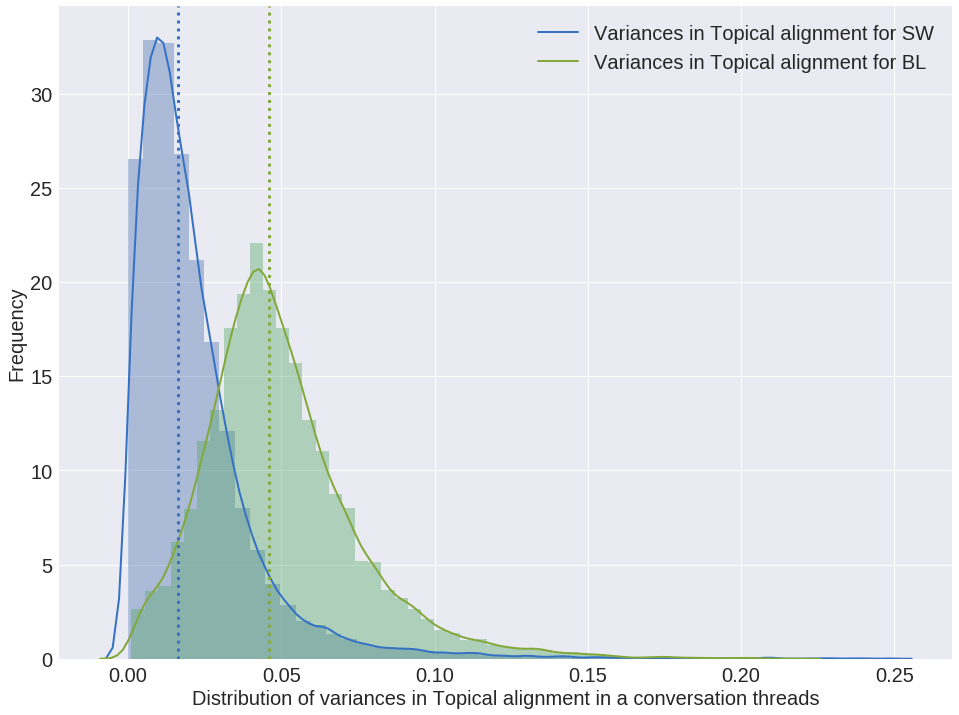

In [60]:
fig, ax = plt.subplots()
fig.set_size_inches(16,12)
sns.set(font_scale=2) 
sns.distplot(SW_edgeVars,kde_kws={"color": "b", "lw": 2, "label": "Variances in Topical alignment for SW"})
sns.distplot(BL_edgeVars,kde_kws={"color": "g", "lw": 2, "label": "Variances in Topical alignment for BL"})
ax.axvline(x=np.median(SW_edgeVars), ymin=0, ymax=1, linewidth=3, color = 'b', linestyle='dotted')
ax.axvline(x=np.median(BL_edgeVars), ymin=0, ymax=1, linewidth=3, color = 'g', linestyle='dotted')
plt.xlabel("Distribution of variances in Topical alignment in a conversation threads" , fontsize = 20)
plt.ylabel("Frequency" , fontsize = 20 )

In [61]:
ReplyGraphs_SW[ReplyGraphs_SW.keys()[101]].nodes(data=True)

[(u't1_c6xmw8s',
  {'affects': 1.0,
   'author': u'bluegerm',
   'depth': 2,
   'downs': 0,
   'text': 'why do you want to run away, are you having problems with your family?',
   'time': 1352263881.0,
   'ups': 2}),
 (u't1_c6xqd6v',
  {'affects': 79.41,
   'author': u'bluegerm',
   'depth': 4,
   'downs': 0,
   'text': "It sounds like you want to escape because you think it's an easy way out of your problems.  It isn't an easy way out, it's just a fantasy.  While you continue the fantasy you'll continue to avoid dealing with the problems with your life and let them build.  One day they may become big enough to make you feel you have no choice.  The real way out is to start facing your problems one by one and begin dealing with them, finding solutions.  You can do it.  You'll grow and change.  Accept the challenge of life and you'll begin to enjoy it.",
   'time': 1352286834.0,
   'ups': 1}),
 (u't1_c6xkqq2',
  {'affects': 25.77,
   'author': u'Kolkhoz',
   'depth': 0,
   'downs': 0,
 

In [62]:
# drawReplyGraph(ReplyGraphs_SW[ReplyGraphs_SW.keys()[101]])

In [63]:
class Tree:
    nxGraph = None
    path = []
    nodes = {}
    visited = []
    def __init__(self,G):
        self.nxGraph = G
        nodes = G.nodes(data=True)
        for n in nodes:
            self.nodes[n[0]] = n[1]
        
    def parseTree(self,node):
        if node != None:
            print self.nodes[node]
            self.visited.append(node)
            inEdges = self.nxGraph.in_edges(node , data=True)
            for k in inEdges:
                if k not in self.visited:
                    print k
                    self.parseTree(k[0])        
    
    def printPath(self):
        print self.path
    

def findLongChains(replyGraphs):
    chains = {}
    for k in replyGraphs:
        print "helllo"
        
        

In [64]:
BL_Graphs[BL_Graphs.keys()[160]].edges(data=True)

[(u'sketh_uwu',
  u'icouldberaff',
  {'timestamp': 1519862865.0, 'weight': 0.03806175217032437}),
 (u'icouldberaff',
  u'icouldberaff',
  {'timestamp': 1519858540.0, 'weight': -0.06477427184581752}),
 (u'icouldberaff',
  u'Unique_username91620',
  {'timestamp': 1519867871.0, 'weight': 0.77733074426651}),
 (u'icouldberaff',
  u'JaxonH',
  {'timestamp': 1519864004.0, 'weight': 0.549007523059845}),
 (u'icouldberaff',
  u'sketh_uwu',
  {'timestamp': 1519862894.0, 'weight': 0.5149914205074311}),
 (u'PerswAsian',
  u'icouldberaff',
  {'timestamp': 1519876445.0, 'weight': 0.2786637127399445}),
 (u'running_fridge',
  u'InuKaT',
  {'timestamp': 1519875382.0, 'weight': 0.3244487822055817}),
 (u'InuKaT',
  u'icouldberaff',
  {'timestamp': 1519873022.0, 'weight': 0.16962066590785985}),
 (u'InuKaT',
  u'Unique_username91620',
  {'timestamp': 1519884637.0, 'weight': 0.266143548488617}),
 (u'InuKaT',
  u'running_fridge',
  {'timestamp': 1519876277.0, 'weight': 0.33201994299888615}),
 (u'platinumpuss8

In [118]:
## this code is extension of Bataglij work on subquadratic triadic census. I am adding a feature to return the nodes in a triad along with vertex tagging.

# triads.py - functions for analyzing triads of a graph
#
# Copyright 2015 NetworkX developers.
# Copyright 2011 Reya Group <http://www.reyagroup.com>
# Copyright 2011 Alex Levenson <alex@isnotinvain.com>
# Copyright 2011 Diederik van Liere <diederik.vanliere@rotman.utoronto.ca>
#
# This file is part of NetworkX.
#
# NetworkX is distributed under a BSD license; see LICENSE.txt for more
# information.
"""Functions for analyzing triads of a graph."""
from __future__ import division

import networkx as nx

__author__ = '\n'.join(['Alex Levenson (alex@isnontinvain.com)',
                        'Diederik van Liere (diederik.vanliere@rotman.utoronto.ca)','Sagar Joglekar (sagar.joglekar@kcl.ac.uk'])

__all__ = ['my_triadic_census']

#: The names of each type of triad.
TRIAD_NAMES = ('003', '012', '102', '021D', '021U', '021C', '111D', '111U',
               '030T', '030C', '201', '120D', '120U', '120C', '210', '300')

#: The integer codes representing each type of triad.
#:
#: Triads that are the same up to symmetry have the same code.
TRICODES = (1, 2, 2, 3, 2, 4, 6, 8, 2, 6, 5, 7, 3, 8, 7, 11, 2, 6, 4, 8, 5, 9,
            9, 13, 6, 10, 9, 14, 7, 14, 12, 15, 2, 5, 6, 7, 6, 9, 10, 14, 4, 9,
            9, 12, 8, 13, 14, 15, 3, 7, 8, 11, 7, 12, 14, 15, 8, 14, 13, 15,
            11, 15, 15, 16)

#: A dictionary mapping triad code to triad name.
TRICODE_TO_NAME = {i: TRIAD_NAMES[code - 1] for i, code in enumerate(TRICODES)}


def triad_graphs():
    """Returns a dictionary mapping triad name to triad graph."""

    def abc_graph():
        """Returns a directed graph on three nodes, named ``'a'``, ``'b'``, and
        ``'c'``.

        """
        G = nx.DiGraph()
        G.add_nodes_from('abc')
        return G

    tg = {name: abc_graph() for name in TRIAD_NAMES}
    tg['012'].add_edges_from([('a', 'b')])
    tg['102'].add_edges_from([('a', 'b'), ('b', 'a')])
    tg['102'].add_edges_from([('a', 'b'), ('b', 'a')])
    tg['021D'].add_edges_from([('b', 'a'), ('b', 'c')])
    tg['021U'].add_edges_from([('a', 'b'), ('c', 'b')])
    tg['021C'].add_edges_from([('a', 'b'), ('b', 'c')])
    tg['111D'].add_edges_from([('a', 'c'), ('c', 'a'), ('b', 'c')])
    tg['111U'].add_edges_from([('a', 'c'), ('c', 'a'), ('c', 'b')])
    tg['030T'].add_edges_from([('a', 'b'), ('c', 'b'), ('a', 'c')])
    tg['030C'].add_edges_from([('b', 'a'), ('c', 'b'), ('a', 'c')])
    tg['201'].add_edges_from([('a', 'b'), ('b', 'a'), ('a', 'c'), ('c', 'a')])
    tg['120D'].add_edges_from([('b', 'c'), ('b', 'a'), ('a', 'c'), ('c', 'a')])
    tg['120C'].add_edges_from([('a', 'b'), ('b', 'c'), ('a', 'c'), ('c', 'a')])
    tg['120U'].add_edges_from([('a', 'b'), ('c', 'b'), ('a', 'c'), ('c', 'a')])
    tg['210'].add_edges_from([('a', 'b'), ('b', 'c'), ('c', 'b'), ('a', 'c'),
                              ('c', 'a')])
    tg['300'].add_edges_from([('a', 'b'), ('b', 'a'), ('b', 'c'), ('c', 'b'),
                              ('a', 'c'), ('c', 'a')])
    return tg


def _tricode(G, v, u, w):
    """Returns the integer code of the given triad.

    This is some fancy magic that comes from Batagelj and Mrvar's paper. It
    treats each edge joining a pair of ``v``, ``u``, and ``w`` as a bit in
    the binary representation of an integer.

    """
    combos = ((v, u, 1), (u, v, 2), (v, w, 4), (w, v, 8), (u, w, 16),
              (w, u, 32))
    return sum(x for u, v, x in combos if v in G[u])


def my_triadic_census(G):
    """Determines the triadic census of a directed graph.

    The triadic census is a count of how many of the 16 possible types of
    triads are present in a directed graph.

    Parameters
    ----------
    G : digraph
       A NetworkX DiGraph

    Returns
    -------
    census : dict
       Dictionary with triad names as keys and number of occurrences as values.

    Notes
    -----
    This algorithm has complexity `O(m)` where `m` is the number of edges in
    the graph.

    References
    ----------
    .. [1] Vladimir Batagelj and Andrej Mrvar, A subquadratic triad census
        algorithm for large sparse networks with small maximum degree,
        University of Ljubljana,
        http://vlado.fmf.uni-lj.si/pub/networks/doc/triads/triads.pdf

    """
    if not G.is_directed():
        raise nx.NetworkXError('Not defined for undirected graphs.')

    # Initialize the count for each triad to be zero.
    census = {name: 0 for name in TRIAD_NAMES}
    census_nodes = {name: [] for name in TRIAD_NAMES}
    taggedNodes = []
    n = len(G)
    # m = dict(zip(G, range(n)))
    m = {v: i for i, v in enumerate(G)}
    for v in G:
        vnbrs = set(G.pred[v]) | set(G.succ[v])
        for u in vnbrs:
            if m[u] <= m[v]:
                continue
            neighbors = (vnbrs | set(G.succ[u]) | set(G.pred[u])) - {u, v}
            # Calculate dyadic triads instead of counting them.
            if v in G[u] and u in G[v]:
                census['102'] += n - len(neighbors) - 2
#                 census_nodes['102'].append([u,v])
            else:
                census['012'] += n - len(neighbors) - 2
#                 census_nodes['012'].append([u,v])
            # Count connected triads.
            for w in neighbors:
                if m[u] < m[w] or (m[v] < m[w] and m[w] < m[u]
                                   and v not in G.pred[w]
                                   and v not in G.succ[w]):
                    code = _tricode(G, v, u, w)
                    census[TRICODE_TO_NAME[code]] += 1
                    census_nodes[TRICODE_TO_NAME[code]].append([v,u,w])

    # null triads = total number of possible triads - all found triads
    #
    # Use integer division here, since we know this formula guarantees an
    # integral value.
    census['003'] = ((n * (n - 1) * (n - 2)) // 6) - sum(census.values())
    print("Calculation Done!!")
    return census, census_nodes




def getApexNode201_111D_021U(triad, G):
#     print triad
    degs = [G.in_degree(i) for i in triad]
    return triad[np.argmax(degs)]

def getMotifAges(G, MotifArray):
    ts =  nx.get_edge_attributes(G,'timestamp').values()
    ts.sort()
    ages = []
    for triad in MotifArray:
        triadAge = []
        for node in triad:
            edges = G[node]
            for n in triad:
                if n in edges:
                    age = (float(edges[n]['timestamp']) - float(ts[0]))/(float(ts[-1]) - float(ts[0]))
                    triadAge.append(age)
        ages.append(np.max(triadAge))
    return ages


'Functions for analyzing triads of a graph.'

In [66]:
# sys.path.append("../Code/")
# import myTriadicCensus
G = BL_Graphs[BL_Graphs.keys()[160]]


22


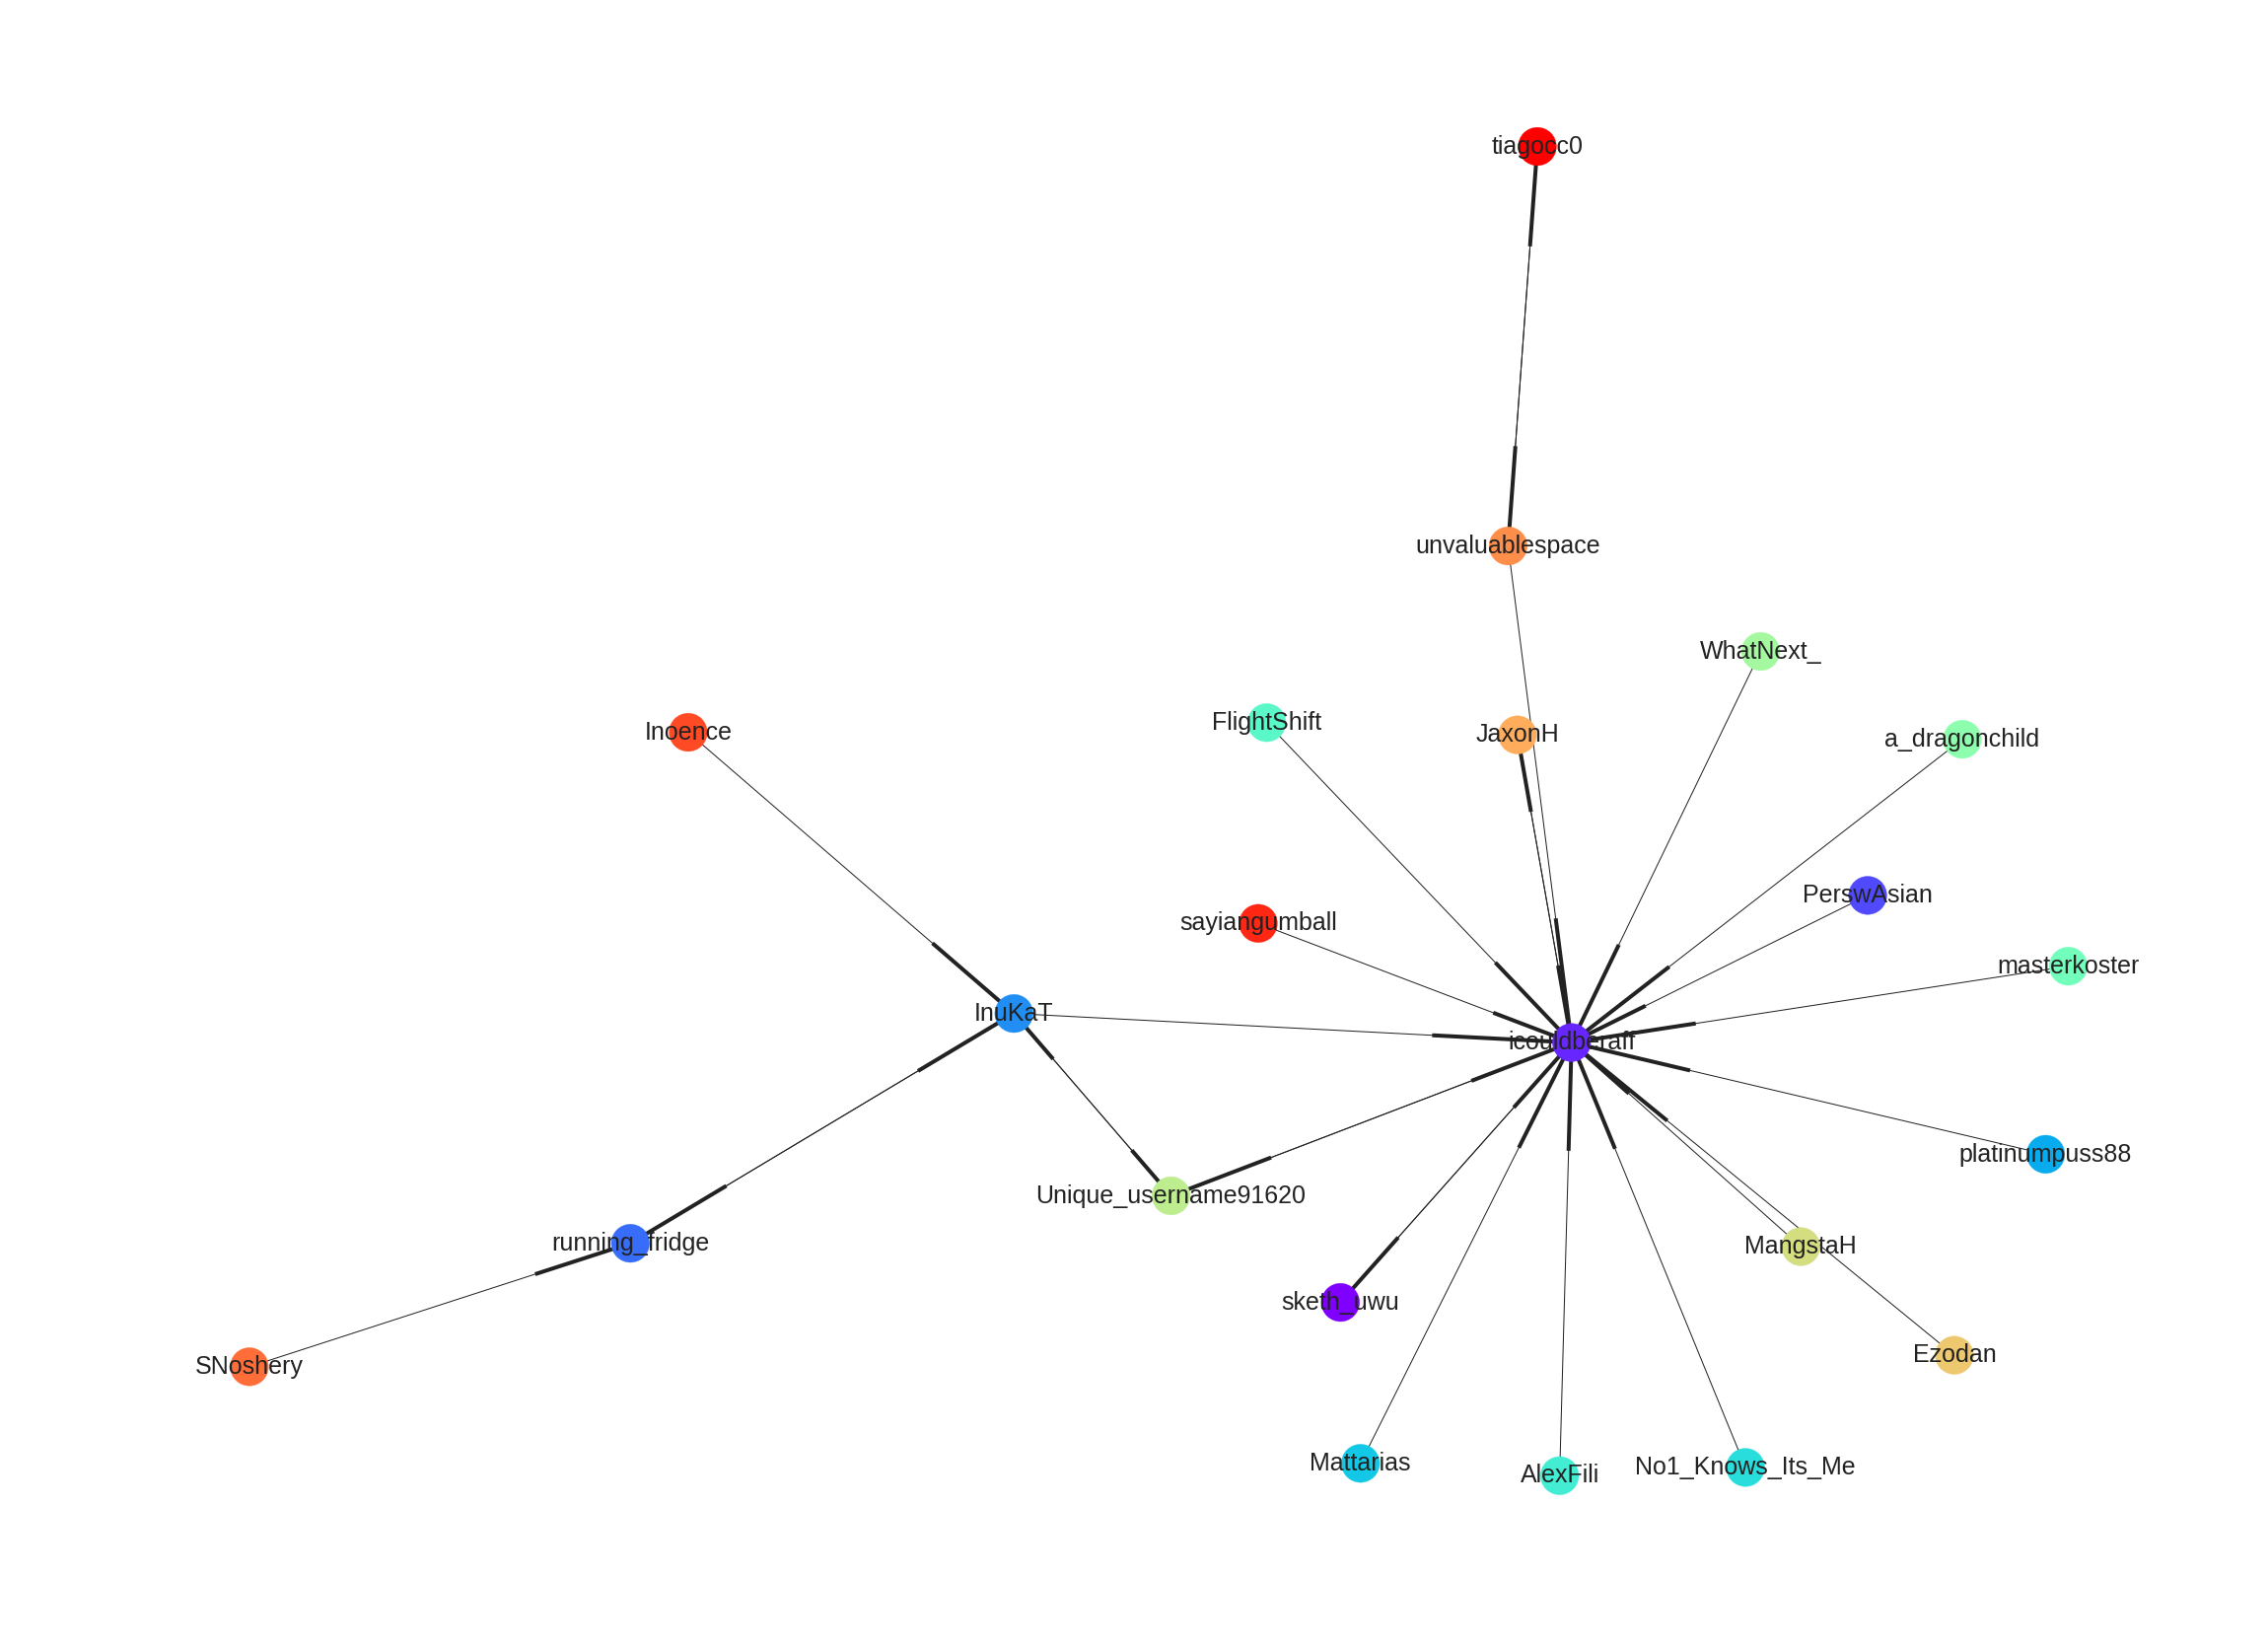

In [67]:
drawUserGraph(BL_Graphs[BL_Graphs.keys()[160]])

In [68]:
G['Unique_username91620']

{u'InuKaT': {'timestamp': 1519883322.0, 'weight': 0.377931821346283},
 u'icouldberaff': {'timestamp': 1519867750.0, 'weight': 0.12245265692472462}}

In [69]:
a =  nx.get_edge_attributes(G,'timestamp').values()
a.sort()
print a[-1] - a[0]

89758.0


In [70]:
keys, triads = my_triadic_census(G)
print keys
for k in triads: 
    print "Triad value for %s"%k
    print triads[k]

Calculation Done!!
{'201': 4, '021C': 1, '021D': 0, '210': 1, '120U': 0, '030C': 0, '003': 1244, '300': 0, '012': 89, '021U': 91, '120D': 0, '102': 64, '111U': 2, '030T': 0, '120C': 0, '111D': 44}
Triad value for 201
[[u'sketh_uwu', u'icouldberaff', u'JaxonH'], [u'sketh_uwu', u'icouldberaff', u'Unique_username91620'], [u'icouldberaff', u'Unique_username91620', u'JaxonH'], [u'running_fridge', u'InuKaT', u'Unique_username91620']]
Triad value for 021C
[[u'icouldberaff', u'InuKaT', u'Inoence']]
Triad value for 021D
[]
Triad value for 210
[[u'icouldberaff', u'InuKaT', u'Unique_username91620']]
Triad value for 120U
[]
Triad value for 030C
[]
Triad value for 003
[]
Triad value for 300
[]
Triad value for 012
[]
Triad value for 021U
[[u'icouldberaff', u'masterkoster', u'a_dragonchild'], [u'icouldberaff', u'masterkoster', u'WhatNext_'], [u'icouldberaff', u'masterkoster', u'sayiangumball'], [u'icouldberaff', u'masterkoster', u'unvaluablespace'], [u'icouldberaff', u'masterkoster', u'MangstaH'], [u

In [71]:
print getApexNode201_111D_021U(triads['111D'][24],G)

[u'icouldberaff', u'Unique_username91620', u'MangstaH']
icouldberaff


In [72]:
print getMotifAges(G,triads['021U'])

[0.0, 0.5642059760689855, 0.16069876779785647, 0.0, 0.5642059760689855, 0.5263709084427015, 0.0, 0.5642059760689855, 0.06804964459992424, 0.0, 0.5642059760689855, 0.11934312261859667, 0.0, 0.5642059760689855, 0.0896187526460037, 0.0, 0.5642059760689855, 0.588437799416208, 0.0, 0.16069876779785647, 0.5263709084427015, 0.0, 0.16069876779785647, 0.06804964459992424, 0.0, 0.16069876779785647, 0.11934312261859667, 0.0, 0.16069876779785647, 0.0896187526460037, 0.0, 0.16069876779785647, 0.588437799416208, 0.0, 0.5263709084427015, 0.06804964459992424, 0.0, 0.5263709084427015, 0.11934312261859667, 0.0, 0.5263709084427015, 0.0896187526460037, 0.0, 0.5263709084427015, 0.588437799416208, 0.0, 0.19948082622161814, 0.5642059760689855, 0.0, 0.19948082622161814, 0.19562601662247375, 0.0, 0.19948082622161814, 0.365438178212527, 0.0, 0.19948082622161814, 0.16069876779785647, 0.0, 0.19948082622161814, 0.5263709084427015, 0.0, 0.19948082622161814, 0.06804964459992424, 0.0, 0.19948082622161814, 0.161344949

In [73]:
def getTriadicCensus(graphs,keys=None):
    triadicCensus = {}
    triadNodes = {}
    if not keys:
        print "No selector dictionary passed"
        keys = graphs.keys()
    for g in keys:
        census, triads = my_triadic_census(graphs[g])
#         denom = len(graphs[g].nodes())+1
        
        triadicCensus[g] = {}
        triadicCensus[g] = census
        triadNodes[g] = {}
        triadNodes[g] = triads
#         for k in triadicCensus[g]:
#             triadicCensus[g][k]= float(triadicCensus[g][k])/float(denom)
    return triadicCensus , triadNodes
    

In [74]:
len(commonKeys_SW) , len(commonKeys_BL)

(9857, 11070)

In [75]:
triads_SW , triadNodes_SW = getTriadicCensus(SW_Graphs,commonKeys_SW)

Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation 

Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation 

Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation 

Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation 

Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation 

Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation 

Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation 

Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation 

Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation 

Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation 

Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation 

Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation 

Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation 

Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation 

In [76]:
triads_BL , triadNodes_BL = getTriadicCensus(BL_Graphs,commonKeys_BL)

Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation 

Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation 

Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation 

Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation 

Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation 

Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation 

Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation 

Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation 

Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation 

Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation 

Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation 

Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation 

Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation 

Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation 

Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation 

Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation 

Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation 

Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation 

Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation 

Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation 

Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation 

Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation 

Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation 

Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation 

In [122]:
def getMotifLifeTimes(Graphs, allTriadNodes):
    lifetimeArray= { '111D' : [] , '201' : [] , '021U' : [] }
    for k in allTriadNodes:
        for m in lifetimeArray.keys():
            lifeTimes = getMotifAges(Graphs[k], allTriadNodes[k][m])
            lifetimeArray[m]+=lifeTimes
    return lifetimeArray

def getApexNodeStat(Graphs , allTriadNodes , opAuthors):
    apexNodeArray= { '111D' : [] , '201' : [] , '021U' : [] }
    for k in allTriadNodes:
        if k in opAuthors:
            for m in apexNodeArray.keys():
                count = 0.0
                frac = 0.0
                for triad in allTriadNodes[k][m]:
                    apexNode = getApexNode201_111D_021U(triad,Graphs[k])
                    if apexNode == opAuthors[k]:
                        count+=1
                if len(allTriadNodes[k][m]) > 0:
                    frac = count/float(len(allTriadNodes[k][m]))
                apexNodeArray[m].append(frac)
    return apexNodeArray

In [100]:
SW_motif_ages = getMotifLifeTimes(SW_Graphs, triadNodes_SW)

In [101]:
BL_motif_ages = getMotifLifeTimes(BL_Graphs, triadNodes_BL)

{'boxes': [<matplotlib.lines.Line2D at 0x7f21052e0350>,
 'caps': [<matplotlib.lines.Line2D at 0x7f21052e0c50>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f21052ef890>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f21052ef490>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7f21052e0450>,
  <matplotlib.lines.Line2D at 0x7f2105303110>]}

([<matplotlib.axis.XTick at 0x7f21056531d0>,
 <a list of 6 Text xticklabel objects>)

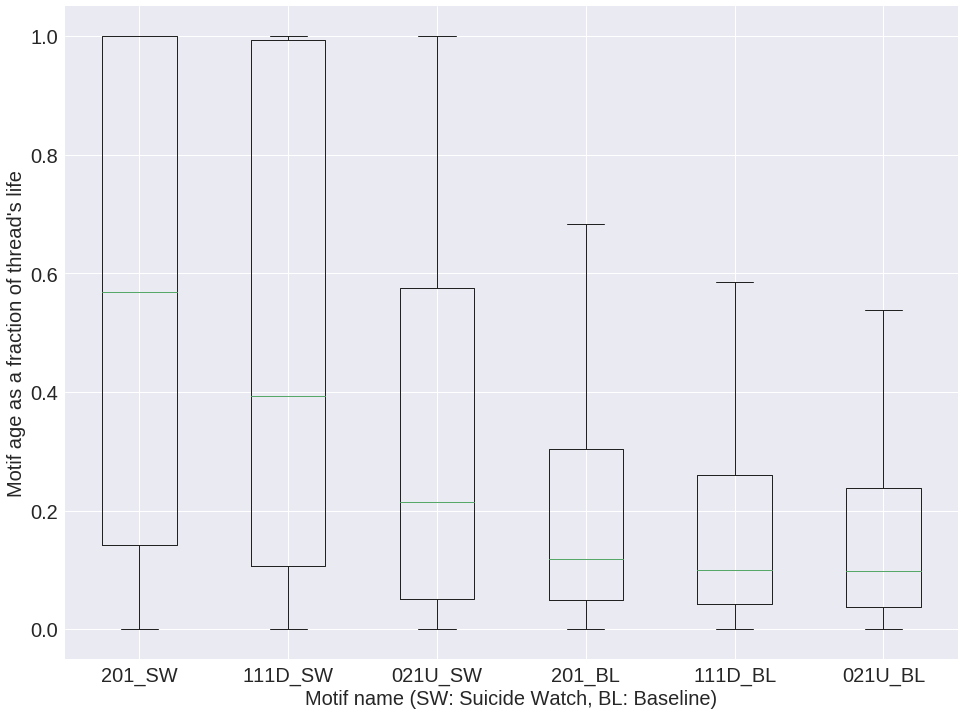

In [111]:
fig, ax = plt.subplots()
fig.set_size_inches(16,12)
data = [SW_motif_ages['201'], SW_motif_ages['111D'], SW_motif_ages['021U'] , BL_motif_ages['201'], BL_motif_ages['111D'], BL_motif_ages['021U']]
# multiple box plots on one figure
plt.boxplot(data)
plt.xlabel("Motif name (SW: Suicide Watch, BL: Baseline)",fontsize = 20)
plt.ylabel("Motif age as a fraction of thread's life",fontsize = 20)
plt.xticks(np.arange(1,len(data)+1,1) , ['201_SW' , '111D_SW' , '021U_SW' ,'201_BL' , '111D_BL' , '021U_BL'])
plt.show()

In [113]:
# n1 , bins1 , patches1 = plt.hist(SW_motif_ages['201'], 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)
# n2 , bins2 , patches2 = plt.hist(SW_motif_ages['111D'], 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)
# n3 , bins3 , patches3 = plt.hist(SW_motif_ages['021U'], 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)

# fig, ax = plt.subplots()
# fig.set_size_inches(15, 10)

# ax.plot(bins1[:-1], n1, 'r', linewidth=2)
# ax.plot(bins2[:-1], n2, 'g', linewidth=2)
# ax.plot(bins3[:-1], n3, 'b', linewidth=2)

# plt.title("Motif age as a fraction of thread's life", fontsize = 20)
# plt.xlabel("Motif Age",fontsize = 20)
# plt.ylabel("P(x) < y",fontsize = 20)
# plt.legend(['Motif ages for 201','Motif ages for 111D' , 'Motif ages for 021U'], loc='top left',fontsize=15)
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)
# # plt.grid()
# plt.show()

In [123]:
ApexOpProportion = getApexNodeStat(SW_Graphs, triadNodes_SW,SW_OpAuthors)

{'boxes': [<matplotlib.lines.Line2D at 0x7f2104f9ba90>,
 'caps': [<matplotlib.lines.Line2D at 0x7f2104fa73d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f2104fb5590>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f2104fa7f10>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7f2104f9bb90>,
  <matplotlib.lines.Line2D at 0x7f2104f65490>]}

([<matplotlib.axis.XTick at 0x7f210501f6d0>,
 <a list of 3 Text xticklabel objects>)

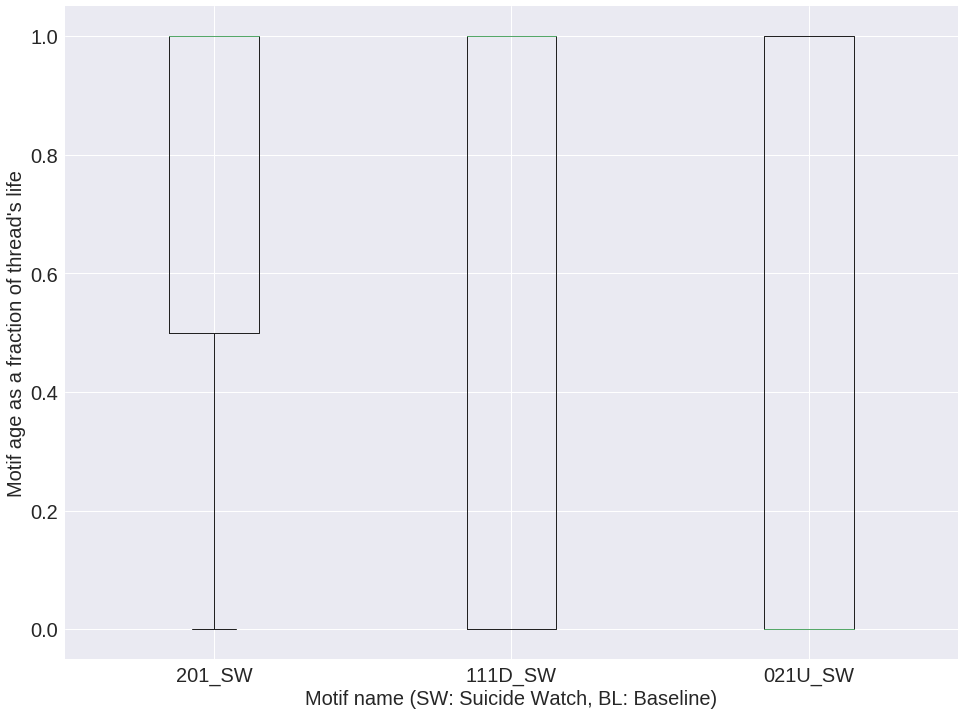

In [125]:
fig, ax = plt.subplots()
fig.set_size_inches(16,12)
data = [ApexOpProportion['201'], ApexOpProportion['111D'], ApexOpProportion['021U'] ]
# multiple box plots on one figure
plt.boxplot(data)
plt.xlabel("Motif name (SW: Suicide Watch, BL: Baseline)",fontsize = 20)
plt.ylabel("Motif age as a fraction of thread's life",fontsize = 20)
plt.xticks(np.arange(1,len(data)+1,1) , ['201_SW' , '111D_SW' , '021U_SW' ,'201_BL' , '111D_BL' , '021U_BL'])
plt.show()

In [82]:
print len(triads_SW), len(triads_BL)

9857 11070


In [83]:
# import json
# json.dump(triads_SW, open("SW_triadic_census_v2.json",'wb'))
# json.dump(triads_BL, open("BL_triadic_census_v2.json",'wb'))

In [490]:
# pkl.dump(file=open("SavedObjs/commonKeys_SW.pkl",'wb'),obj=commonKeys_SW)
# pkl.dump(file=open("SavedObjs/commonKeys_BL.pkl",'wb'),obj=commonKeys_BL)

# pkl.dump(file=open("SavedObjs/branching_BL.pkl",'wb'),obj=BL_branching)
# pkl.dump(file=open("SavedObjs/branching_SW.pkl",'wb'),obj=SW_branching)

In [229]:
dim = keys[7]
SW_vals = [triads_SW[k][dim] for k in triads_SW]
BL_vals = [triads_BL[k][dim] for k in triads_BL]

In [230]:
# print SW_repVals

In [231]:
# SW_repVals = [repTriads_SW[k][dim] for k in repTriads_SW]
# BL_repVals = [repTriads_BL[k][dim] for k in repTriads_BL]

In [232]:
x , y = powerlaw.ccdf(SW_vals)
x2,y2 = powerlaw.ccdf(BL_vals)

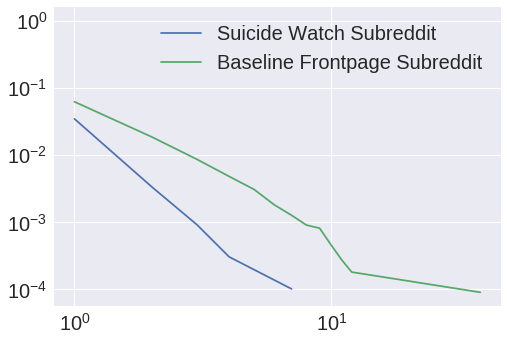

In [233]:
plt.loglog(x,y)
plt.loglog(x2,y2)
plt.legend(['Suicide Watch Subreddit', 'Baseline Frontpage Subreddit'])

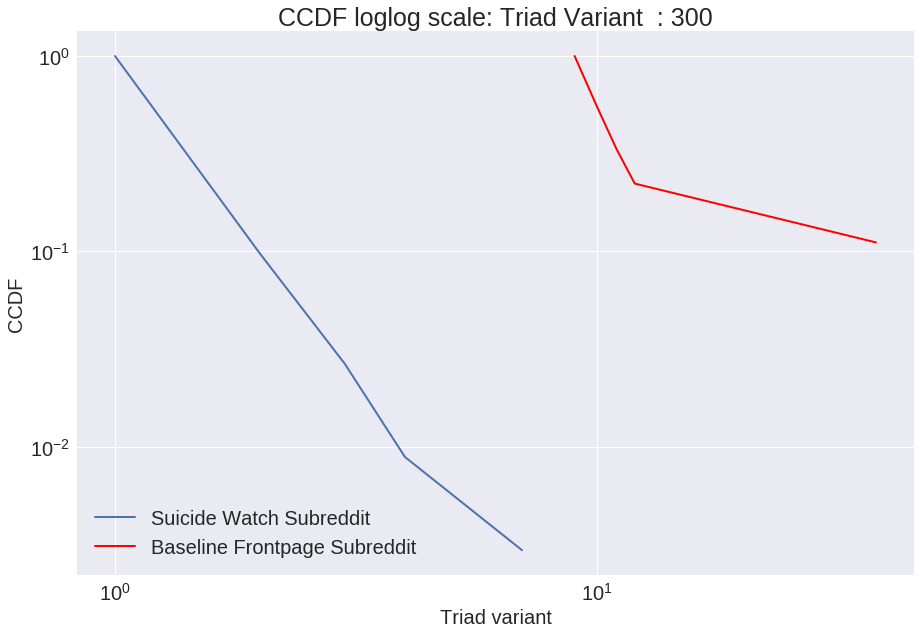

In [234]:
fit_SW = powerlaw.Fit(SW_vals)
fit_BL = powerlaw.Fit(BL_vals)

fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
plt.title("CCDF loglog scale: Triad Variant  : " + dim, fontsize = 25)
plt.xlabel("Triad variant",fontsize = 20)
plt.ylabel("CCDF",fontsize = 20)
fig2=fit_SW.plot_ccdf(linewidth=2)
fit_BL.plot_ccdf(color='r', linewidth=2, ax=fig2)
plt.legend(['Suicide Watch Subreddit', 'Baseline Frontpage Subreddit'])

In [235]:
# fit_SW = powerlaw.Fit(SW_repVals)
# fit_BL = powerlaw.Fit(BL_repVals)

# fig, ax = plt.subplots()
# fig.set_size_inches(15, 10)
# plt.title("CCDF loglog scale: Triad Variant  : " + dim, fontsize = 25)
# plt.xlabel("Triad variant",fontsize = 20)
# plt.ylabel("CCDF",fontsize = 20)
# fig2=fit_SW.plot_ccdf(linewidth=2)
# fit_BL.plot_ccdf(color='r', linewidth=2, ax=fig2)
# plt.legend(['Suicide Watch Subreddit', 'Baseline Frontpage Subreddit'])

In [236]:
SW_sizes = {}
for k in commonKeys_SW:
    SW_sizes[k] = len(SW_Graphs[k].nodes())
BL_sizes = {}
for k in commonKeys_BL:
    BL_sizes[k] = len(BL_Graphs[k].nodes())

In [237]:
print len(SW_sizes), len(BL_sizes)

9857 11070


In [238]:
from scipy.stats import sem

def getSizeDict(graphs):
    sizes = {}
    for k in graphs:
        sizes[k] = len(graphs[k].nodes())
    return sizes 

def getRandomGraphCensus(n , p , graphCount ):
    graphs= {}
    for k in range(graphCount):
        g = nx.erdos_renyi_graph(n, p, seed=None, directed=True)
        graphs[str(k)] = g
    randomCensus = getTriadicCensus(graphs)
    return randomCensus
    
    
def getNodeMotifSpread(graphs , listSizeSpread):
    sizes = {}
    for k in graphs:
        sizes[k] = len(graphs[k].nodes())
    census_graph = {}
    census_random = {}
    #iterate through graph size spread
    for s in listSizeSpread:
        print "Working with Size %d" %s
        subset_graphs = dict()
        for k in sizes:
            if sizes[k] == s:
                subset_graphs[k] = graphs[k]
        print "Working with %d Selected Graphs" %len(subset_graphs.keys())
        randomCensus = getRandomGraphCensus(len(subset_graphs.keys()),0.2,s)
        graphCensus = getTriadicCensus(subset_graphs)
        
        census_graph[s] = graphCensus
        census_random[s] = randomCensus
    return census_graph , census_random

def getNodeMotifBinnedSpread(graphs , startNodeCount , stopNodeCount, binSize):
    sizes = {}
    for k in graphs:
        sizes[k] = len(graphs[k].nodes())
    census_graph = {}
    #iterate through graph size spread
    binCount = 0
    for (start,stop) in zip(range(startNodeCount,stopNodeCount,binSize),range(startNodeCount+binSize,stopNodeCount+binSize,binSize)):
        print "Working with Size %d - %d"%(start,stop)
        subset_graphs = dict()
        for k in sizes:
            if (sizes[k] > start and sizes[k]<=stop):
                subset_graphs[k] = graphs[k]
        print "Working with %d Selected Graphs" %len(subset_graphs.keys())
        
        graphCensus = getTriadicCensus(subset_graphs)
        census_graph[binCount] = graphCensus
        binCount+=1
    return census_graph , binCount


def getCountsForMotifs(censusSpread,MotifKey):
    Counts = {}
    errors = {}
    for k in censusSpread:
        presence = 0
        count = [0]
        for g in censusSpread[k]:
            
            if censusSpread[k][g][MotifKey] > 0:
#                 presence+=censusSpread[k][g][MotifKey]
                count.append(censusSpread[k][g][MotifKey])
#         Counts[k] = float(presence)/float(len(censusSpread[k].keys()))
        Counts[k] = np.mean(count)
        errors[k] = sem(count)
    return Counts , errors


def getAllMotifCounts(spread , motifKey , nodeNumbers):
    counts = []
    for k in spread[nodeNumbers]:
        if motifKey in spread[nodeNumbers][k]:
            counts.append(spread[nodeNumbers][k][motifKey])
    return counts


def calculateZscore(TargetSpread , baselineSpread):
    triad_names = ['003', '012', '102', '021D', '021U', '021C', '111D', '111U','030T', '030C', '201', '120D', '120U', '120C', '210', '300']
    Zscores = {}
    for k in TargetSpread:
        for motifKey in triad_names:
            if motifKey not in Zscores:
                Zscores[motifKey] = []
            target = getAllMotifCounts(TargetSpread,motifKey,k)
            baseline = getAllMotifCounts(baselineSpread,motifKey,k)
            
            std = np.std(baseline)
            print std , len(baseline)
            
            z = (float(np.sum(target)) - float(np.sum(baseline)))/std
            Zscores[motifKey].append(z)
    return Zscores

In [239]:
randomCensus = getRandomGraphCensus(30,0.3,100)
    

No selector dictionary passed


In [240]:
motifVals = [randomCensus[k]['300'] for k in randomCensus]
SW_motifVals = [triads_SW[k]['300'] for k in  triads_SW if SW_sizes[k] == 30 ] 
BL_motifVals = [triads_BL[k]['300'] for k in  triads_BL if BL_sizes[k] == 30] 

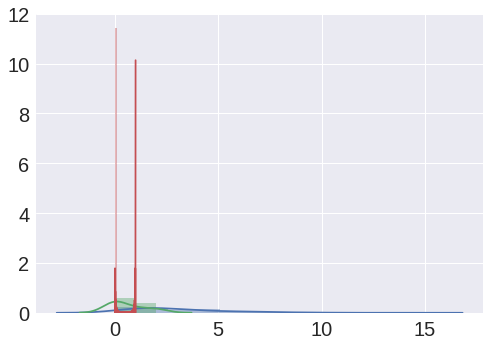

In [241]:
sns.distplot(motifVals)
sns.distplot(SW_motifVals)
sns.distplot(BL_motifVals)

In [242]:
randomCensus['9']

{'003': 522,
 '012': 1304,
 '021C': 565,
 '021D': 266,
 '021U': 251,
 '030C': 82,
 '030T': 251,
 '102': 244,
 '111D': 186,
 '111U': 175,
 '120C': 77,
 '120D': 42,
 '120U': 47,
 '201': 27,
 '210': 20,
 '300': 1}

In [243]:
# SW_census_spread , R_census_spread = getNodeMotifSpread(SW_Graphs , [10 , 12 , 15 , 18 , 20 , 22 ,  25 , 28, 30])
SW_census_spread , bins = getNodeMotifBinnedSpread(SW_Graphs ,binSize=5 ,startNodeCount=1 , stopNodeCount=40)

Working with Size 1 - 6
Working with 6596 Selected Graphs
No selector dictionary passed
Working with Size 6 - 11
Working with 2926 Selected Graphs
No selector dictionary passed
Working with Size 11 - 16
Working with 674 Selected Graphs
No selector dictionary passed
Working with Size 16 - 21
Working with 192 Selected Graphs
No selector dictionary passed
Working with Size 21 - 26
Working with 65 Selected Graphs
No selector dictionary passed
Working with Size 26 - 31
Working with 36 Selected Graphs
No selector dictionary passed
Working with Size 31 - 36
Working with 11 Selected Graphs
No selector dictionary passed
Working with Size 36 - 41
Working with 10 Selected Graphs
No selector dictionary passed


In [244]:
# BL_census_spread , R_census_spread = getNodeMotifSpread(BL_Graphs , [10 , 12 , 15 , 18 , 20 , 22 ,  25 , 28, 30])
BL_census_spread , bins = getNodeMotifBinnedSpread(BL_Graphs ,binSize=5 ,startNodeCount=1 , stopNodeCount=40)

Working with Size 1 - 6
Working with 107 Selected Graphs
No selector dictionary passed
Working with Size 6 - 11
Working with 1492 Selected Graphs
No selector dictionary passed
Working with Size 11 - 16
Working with 1907 Selected Graphs
No selector dictionary passed
Working with Size 16 - 21
Working with 1416 Selected Graphs
No selector dictionary passed
Working with Size 21 - 26
Working with 1029 Selected Graphs
No selector dictionary passed
Working with Size 26 - 31
Working with 737 Selected Graphs
No selector dictionary passed
Working with Size 31 - 36
Working with 672 Selected Graphs
No selector dictionary passed
Working with Size 36 - 41
Working with 458 Selected Graphs
No selector dictionary passed


In [245]:
print bins

8


In [246]:
# BL_census_spread[BL_census_spread.keys()[2]]

In [247]:
def getSequentialValues(presenceCensus , spread):
    return [presenceCensus[k] for k in spread]

In [248]:
keys = nx.triadic_census(BL_Graphs[BL_Graphs.keys()[160]]).keys()
print keys

['201', '021C', '021D', '210', '120U', '030C', '003', '300', '012', '021U', '120D', '102', '111U', '030T', '120C', '111D']


In [249]:

triad_names = ['003', '012', '102', '021D', '021U', '021C', '111D', '111U','030T', '030C', '201', '120D', '120U', '120C', '210', '300']

In [317]:
dim = triad_names[15]
BL_presenceRatio , BL_errors = getCountsForMotifs(BL_census_spread,dim)
# randomRatio = getCountsForMotifs(R_census_spread,dim)
SW_presenceRatio, SW_errors = getCountsForMotifs(SW_census_spread,dim)

In [318]:
print getSequentialValues(SW_presenceRatio, range(bins))#[10 , 12 , 15 , 18 , 20 , 22 ,  25 , 28, 30])
print getSequentialValues(BL_presenceRatio, range(bins))#[10 , 12 , 15 , 18 , 20 , 22 ,  25 , 28, 30])
# print getSequentialValues(randomRatio,[10 , 12 , 15 , 18 , 20 , 22 ,  25 , 28, 30])

[1.0186335403726707, 1.1228070175438596, 1.2413793103448276, 1.2380952380952381, 1.1666666666666667, 1.2857142857142858, 0.5, 2.6666666666666665]
[0.75, 0.9090909090909091, 1.0, 1.0512820512820513, 1.09375, 1.1538461538461537, 1.2916666666666667, 1.1333333333333333]


In [319]:
def getXticks(startNodeCount , stopNodeCount, binSize):
    ticks = []
    for (start,stop) in zip(range(startNodeCount,stopNodeCount,binSize),range(startNodeCount+binSize,stopNodeCount+binSize,binSize)):
        ticks.append(str(start)+"-"+str(stop-1))
    return ticks

<Container object of 8 artists>

<Container object of 8 artists>

([<matplotlib.axis.XTick at 0x7fefbc32af50>,
 <a list of 8 Text xticklabel objects>)

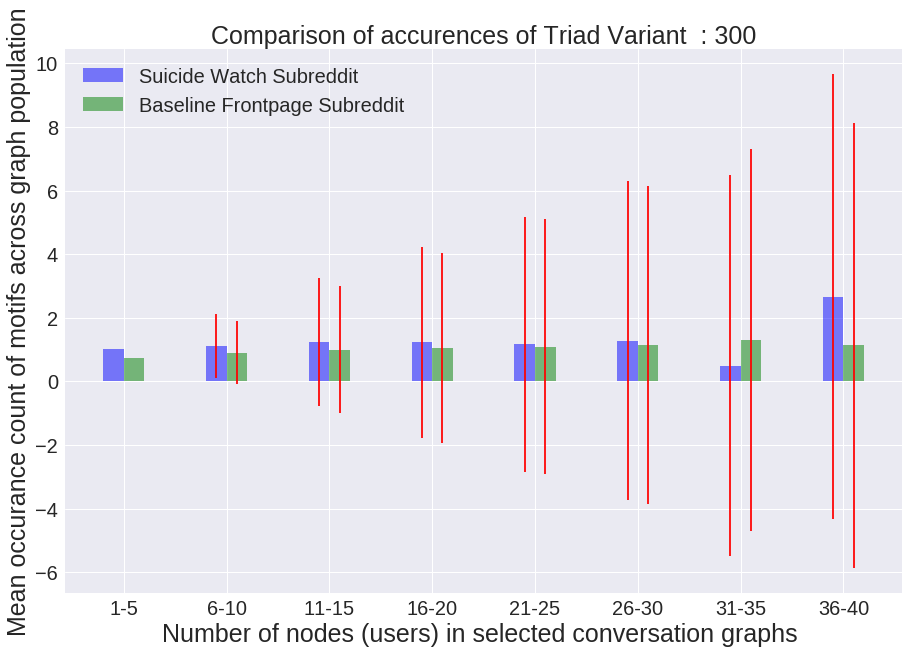

In [320]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
plt.title("Comparison of accurences of Triad Variant  : " + dim, fontsize = 25)
plt.xlabel("Number of nodes (users) in selected conversation graphs ",fontsize = 25)
plt.ylabel("Mean occurance count of motifs across graph population",fontsize = 25)
x = np.arange(bins)
y1 = getSequentialValues(SW_presenceRatio, range(bins))
y2 = getSequentialValues(BL_presenceRatio, range(bins))
ax.bar(x-0.1, y1 ,width=0.2, color='b',yerr = SW_errors, align='center', alpha=0.5, ecolor='red', capsize=10)
ax.bar(x+0.1, y2 ,width=0.2, color='g',yerr = BL_errors, align='center', alpha=0.5, ecolor='red', capsize=10)

# plt.plot(getSequentialValues(SW_presenceRatio, range(bins)))#[10 , 12 , 15 , 18 , 20 , 22 ,  25 , 28, 30]))
# plt.errorbar(getSequentialValues(SW_presenceRatio, range(bins)), np.arange(1,40,3), yerr=SW_errors, fmt='.k')
# plt.plot(getSequentialValues(BL_presenceRatio, range(bins)))#[10 , 12 , 15 , 18 , 20 , 22 ,  25 , 28, 30]))

plt.xticks(np.arange(bins), getXticks(1,40,5))
plt.legend(['Suicide Watch Subreddit', 'Baseline Frontpage Subreddit'])

In [316]:
# fig, ax = plt.subplots()
# fig.set_size_inches(15, 10)
# plt.title("Comparison of accurences of Triad Variant  : " + dim, fontsize = 25)
# plt.xlabel("Number of Nodes in Selected Graphs ",fontsize = 25)
# plt.ylabel("Fraction of Graphs with motif present",fontsize = 25)
# plt.xticks(np.arange(8),[10 , 12 , 15 , 18 , 20 , 22 ,  25 , 28, 30])
# SW_result = getSequentialValues(SW_presenceRatio,[10 , 12 , 15 , 18 , 20 , 22 ,  25 , 28, 30])
# BL_result = getSequentialValues(BL_presenceRatio,[10 , 12 , 15 , 18 , 20 , 22 ,  25 , 28, 30])
# plt.plot([SW_result[i]/BL_result[i] for i in range(len(BL_result))])
# plt.legend(['Ratio of Motif foound in SW to those in BL'])

In [ ]:
triads = nx.triads.triad_graphs()

In [ ]:
Zscores = calculateZscore(SW_census_spread,R_census_spread)

In [ ]:
sns.distplot([Zscores[k]

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
pos = graphviz_layout(triads[triad_names[6]], prog='neato')
nx.draw(triads[triad_names[6]], pos=pos ,node_size=1500)